In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import anndata as ad
import scanpy as sc
import scipy.stats as stats
import statsmodels.api as sm
import scipy.stats as stats 
from scipy.stats import pearsonr, spearmanr
from scipy.stats import mannwhitneyu
import statsmodels.api as sm
import create_dataset
import anndata as ad
import shap
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold, LeaveOneOut,KFold, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
from sklearn.feature_selection import VarianceThreshold, SelectKBest
from sklearn.feature_selection import f_regression
from statannotations.Annotator import Annotator

%matplotlib inline

In [5]:
path_data = "../data/"
savedir = "../output/"
path_samples = path_data + "single_events_data/"
metadata = pd.read_csv(path_data + "Metadata.csv")
measures = pd.read_excel(path_data + "phenotypes.xlsx")
retrain=False

In [6]:
### load syntof
df, markers = create_dataset.createDataset(metadata, path_samples)
print(len(markers))

30


In [7]:
## create mean expression
df_mean = df[markers + ["Subject_name","Sample_name"]]
map_id2diet = {ii:dt for ii,dt in list(zip(df["Subject_name"].values,
                                            df["Diet"].values))}
df_mean = df_mean.groupby(["Subject_name","Sample_name"]).mean()
df_mean = df_mean.reset_index()
df_mean["Diet"] = df_mean["Subject_name"].map(map_id2diet).values
df_mean.head(3)

,Subject_name,Sample_name,89Y_EAAT1_(Y89Di),113In_VMAT2_(In113Di),115In_Synaptobrevin2_(In115Di),141Pr_LRRK2_(Pr141Di),142Nd_a-Synuclein_(Nd142Di),143Nd_GFAP_(Nd143Di),144Nd_PARKIN_(Nd144Di),146Nd_Casp3_Acti_(Nd146Di),...,166Er_PrP_CD230_(Er166Di),167Er_ApoE_(Er167Di),168Er_b-Amyloid_X40_(Er168Di),169Tm_GAD65_(Tm169Di),170Er_GAMT_2_(Er170Di),171Yb_LC3B_(Yb171Di),173Yb_APP_(Yb173Di),174Yb_K48-Ubiquitin_(Yb174Di),176Lu_SLC6A8_(Lu176Di),Diet
0,8358,c18_BC010_8358,0.137969,0.149702,0.078218,0.177382,0.259251,0.137234,0.032072,0.176338,...,0.166064,0.046320,0.130675,0.322417,0.094395,0.207678,0.200007,0.143623,0.034597,western
1,8359,c05_BC010_8359,0.150594,0.166086,0.100991,0.234381,0.578238,0.102486,0.039728,0.334536,...,0.159278,0.061094,0.235539,0.429770,0.124311,0.252061,0.313111,0.260062,0.052619,mediterranean
2,8360,c10_BC009_8360,0.196587,0.174706,0.148033,0.157442,0.551730,0.093847,0.034285,0.126716,...,0.536835,0.062191,0.128906,0.382986,0.088115,0.228927,0.370566,0.183872,0.042042,western


In [8]:
##Load bulk data
bulk = pd.read_csv(path_data + "bulk_rna.csv").set_index("gene_name").T
bulk
col_bulk = bulk.columns.tolist()
bulk = bulk.groupby(bulk.columns, axis=1).sum()

##binarize bulk and remove l
bin_bulk = np.asarray(bulk.copy().values)
bin_bulk[bin_bulk>0] = 1


/var/folders/yn/qvpxfrdd5870gxhq9hf9jvc40000gq/T/ipykernel_47686/2513055043.py:5: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  bulk = bulk.groupby(bulk.columns, axis=1).sum()


In [9]:
##use common subjects
df_mean = df_mean[df_mean.Subject_name.isin(bulk.index.tolist())]
bulk = bulk.loc[df_mean.Subject_name.tolist(), :]

In [10]:
##combine data
adata = ad.AnnData(bulk)
adata.obs["sample_id"] = bulk.index.tolist()
adata.var["gene_name"] = bulk.columns.tolist()
for it in df_mean.columns:
    adata.obs[it] = df_mean[it].values

X = adata.to_df().values

In [8]:
##remove less variable genes
import filtering_methods as ft
quasi_constant_feature = ft.constant_feature_detect(data=adata.to_df(),threshold=0.9)

len(quasi_constant_feature)
adata = adata[:,~adata.var["gene_name"].isin(quasi_constant_feature)]
X = adata.to_df().values
meta = adata.obs
com = adata.var.gene_name.tolist()
X.shape

4271  variables are found to be almost constant


(36, 27474)

# With features selection

In [9]:
if retrain:

    # from sklearn_relief import Relief
    # import xgboost
    #cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    np.random.seed(31415) 
    list_k = [4,8,12,16,20,30, 40,50,80, 100, 150]
    list_models = ['Linear Regression', #'KNN', 
                  'Decision Tree',] 
        
                    #'Random Forest']
    models = {
                        'Linear Regression':LinearRegression(),
                        #"Logistic Regression":LogisticRegression(),
                        'Decision Tree': DecisionTreeRegressor(random_state=1),
                                #'EN': LogisticRegression(penalty='elasticnet', l1_ratio=0.5, fit_intercept=False, solver='saga', max_iter=10000), #'EN': customLogisticRegressionCV(cv=5, l1_ratios=[0, 0.25, 0.5, 0.75, 1], fit_intercept=False),
                               # 'LASSO': LogisticRegression(penalty='l1', fit_intercept=False, solver='saga', max_iter=10000), #customLogisticRegressionCV(cv=5, l1_ratios=[1], fit_intercept=False), #
                               # 'Ridge': LogisticRegression(penalty='l2', fit_intercept=False), #customLogisticRegressionCV(cv=5, l1_ratios=[0], fit_intercept=False), #
                                'Random Forest': RandomForestRegressor(random_state=1),
                                'KNN': KNeighborsRegressor(),
                                #'SVM': SVC(probability=True),  #rbf for AD, linear for LBD
                                #'XGBoost': XGBClassifier(n_jobs=-1, booster='gblinear', objective='binary:logistic')
                            }
    methods = ["shap"]#,"normal"]
    test_feats = [5,10,20,40,60, 80,100,150]
    index = [mm+"_"+m+"_"+method+"_"+str(ff) for mm in list_models for m in markers for method in methods for ff in test_feats]
    
    # res = pd.DataFrame(np.zeros((len(list_de)*len(list_models), 8)), index=list_de, columns=["n_features", "marker","algo", 'Pearson','Spearman', 'Pvalue(Pearson)','Pvalue(Spearman)','MAPE' ])
    res = pd.DataFrame(np.zeros((len(markers)*len(list_models)*len(methods)*len(test_feats), 9)),
                       index=index, columns=["n_features", "marker","algo", 'Pearson','Spearman',
                                                                                           'Pvalue(Pearson)','Pvalue(Spearman)','MAPE', "Method"])
    
    y_preds = {mm+"_"+m:pd.DataFrame(np.zeros((len(X), 1)), columns=['y_pred']) for mm in list_models for m in markers}

    inner_cv = StratifiedKFold(n_splits=10,shuffle=True)
    n_out_splits = 10
    outer_cv2 = RepeatedStratifiedKFold(n_splits=n_out_splits,n_repeats=50,  random_state=1)
    outer_cv = StratifiedKFold(n_splits=10,shuffle=True)
    outer_cv_results = {key: [] for key in ["marker","outer_split", "n_features", "algo", "mae", "method"]}
    
    loo = LeaveOneOut()
    
    w_out = {it+"_"+mm+"_"+method+"_"+str(ff):np.zeros((n_out_splits, X.shape[1])) for it in list_models for mm in markers for method in methods for ff in test_feats}
    
    w_algo = {it+"_"+mm+"_"+method+"_"+str(ff):np.zeros((len(X), X.shape[1])) for it in list_models for mm in markers for method in methods for ff in test_feats}
    
    
    # method="normal"
    for method in methods:
        print(method)
        for algo in list_models:
            for it in markers:
                y = kk[it].values
                #print(y.shape)
                for ff, n_features in enumerate(test_feats):
    
                    for i1, (train_index, test_index) in enumerate(outer_cv.split(X, kk["Diet"])):
                        X_train, X_test = X[train_index, :], X[test_index, :]
                        y_train, y_test = y[train_index], y[test_index]
                    
                    
                        inner_cv_results = {key: [] for key in ["marker","outer_split", "inner_split", "n_features", "algo", "mae", "index"]}
                     # print(n_features)
                        # y_preds_inner = {mm+"_"+m+"_"+str(ff) :pd.DataFrame(np.zeros((len(X_train), 1)), columns=['y_pred']) for mm in models for m in markers for ff in test_feats }
                        # y_inner = {mm+"_"+m+"_"+str(ff) :pd.DataFrame(np.zeros((len(X_train), 1)), columns=['y_pred']) for mm in models for m in markers for ff in test_feats }
                        nb_inner = len(list(inner_cv.split(X_train, kk.iloc[train_index,:]["Diet"])))
                        w_in = np.zeros((nb_inner, X.shape[1])) 
                        name = algo+"_"+it+"_"+method+"_"+str(n_features)
                        for i2, (train_inner, test_inner) in enumerate(inner_cv.split(X_train, kk.iloc[train_index,:]["Diet"])):
                                X_train_inner, X_test_inner = X_train[train_inner,:], X_train[test_inner,:]
                                y_train_inner, y_test_inner = y_train[train_inner], y_train[test_inner]


                                #for k in list_k:
                                clf = models[algo]
                                # name2 = algo+"_"+it+"_"+str(n_features)
                                
    
                                # ft = Relief(n_features=n_features)
                                scaler = StandardScaler()
                                pipe = Pipeline([("scale", scaler),
                                       # ("selection", ft),
                                    #("featureselection" , VarianceThreshold()),
                                                 #("featureSelection", SelectKBest(f_regression, k=k)),
                                          #("reduce_dims", PCA()),
                                         ("model", clf)
                                         ])
    
                                pipe.fit(np.array(X_train_inner), np.array(y_train_inner))
                                # if algo in ['LASSO', 'Ridge']:
                                    # y_pred = np.array(clf.best_estimator_.predict_proba(np.array(X_test))[:, 1])
                                # else:
                                y_pred = np.array(pipe.predict(np.array(X_test_inner)))
                                #ind = ft.w_
                                if method == "normal":
                                    if algo =="Linear Regression":
                                        w_ = np.abs(clf.coef_)
                                    else:
                                         w_ = clf.feature_importances_
                                elif method=="shap":
                                    X_std = scaler.transform(np.array(X_test_inner))
                                    if algo =="Linear Regression":
                                        explainer = shap.explainers.Linear(clf,X_std)
                                        shap_values = explainer(X_std).values
                                    else:
                                        explainer = shap.TreeExplainer(clf)
                                        shap_values = explainer(X_std).values
                                    w_ = np.abs(shap_values).mean(0)
                                feat_indices = np.flip(np.argsort(w_), 0)[0:n_features]
    
                                w_in[i2, feat_indices] = 1 
                                    #y_preds_inner[name].loc[test_inner,:] = y_pred
                                    #y_inner[name].loc[test_inner,:] = y_test_inner
    
                                inner_cv_results["outer_split"].append(i1 + 1)
                                inner_cv_results["inner_split"].append(i2 + 1)
                                inner_cv_results["n_features"].append(n_features)
                                inner_cv_results["index"].append(i2)
    
                                inner_cv_results["algo"].append(algo)
    
                                inner_cv_results["marker"] = it
                                    #inner_cv_results["pearson"].append(pearsonr(y_test_inner, y_pred)[0])
                                    #inner_cv_results["spearman"].append(spearmanr(y_test_inner, y_pred)[0])
                                inner_cv_results["mae"].append(mean_absolute_error(y_test_inner, y_pred))
    
    
                        best_feat = inner_cv_results["n_features"][np.where(inner_cv_results["mae"]==np.min(inner_cv_results["mae"]))[0][0]]
    
                        # print(best_feat)
                        valid_index = np.where(np.asarray(inner_cv_results["n_features"]) == best_feat)[0]
                        w_best = w_in.sum(0)
                        #print(w_best.shape)
    
                        indx = sorted(range(len(w_best)), key=lambda i: w_best[i])[-n_features:]
                        w_final = np.zeros_like(w_best)
                        w_final[indx] = 1
                        w_out[name][i1,:] = w_final
    
                        scaler = StandardScaler()
                        pipe = Pipeline([("scale", scaler),
                                    #("featureselection" , VarianceThreshold()),
                                                 #("featureSelection", ReliefF(),# SelectKBest(f_regression, k=int(best_k))),
                                          #("reduce_dims", PCA()),
                                         ("model", models[algo])
                                         ])
                        indexxx = np.where(w_final>0)[0]
                        pipe.fit(np.array(X_train[:,indexxx]), np.array(y_train))
                                # if algo in ['LASSO', 'Ridge']:
                                    # y_pred = np.array(clf.best_estimator_.predict_proba(np.array(X_test))[:, 1])
                                # else:
                        y_pred = np.array(pipe.predict(np.array(X_test[:, indexxx])))
                             # Store results
                        outer_cv_results["marker"].append(it)
                        outer_cv_results["outer_split"].append(i1)
                        outer_cv_results["n_features"].append(best_feat)
                        outer_cv_results["algo"].append(algo)
                        outer_cv_results["method"] = method
                        outer_cv_results["mae"].append(mean_absolute_error(y_test, y_pred))
                    out_selection = pd.DataFrame(outer_cv_results)
                    out_selection = out_selection[(out_selection.marker == it)
                                                  &(out_selection.algo==algo)].sort_values("mae")
                    outer_selection_split = out_selection.iloc[0]["outer_split"]
                    best_it = out_selection.iloc[0]["outer_split"]
                    w_best = w_out[name][best_it, :]
                    # w[w>0] =1
                    # w_best = w.sum(0)
                    # print(w_best.shape)
                    # w_best[w_best<w.shape[0]] =0
                    # w_best[w_best>0]=1
                    # name = algo+"_"+it+"_"+method
    
                    w_algo[name] = w_best
                    feat_index = np.where(w_best>0)[0]
                    # if out_selection.iloc[0]["n_features"] == X.shape[-1]:
                    #     feat_index = [it for it in range(X.shape[-1])]
                    tmp = pd.DataFrame(columns=range(len(X)))
                    for i3, (train_index, test_index) in enumerate(outer_cv2.split(X,kk["Diet"])):
                        X_train, X_test = X[train_index, :], X[test_index, :]
                        y_train, y_test = y[train_index], y[test_index]
                        scaler = StandardScaler()
                        clf =models[algo]
                        pipe = Pipeline([("scale", scaler),
                                    #("featureselection" , VarianceThreshold()),
                                                 #("featureSelection", ReliefF(),# SelectKBest(f_regression, k=int(best_k))),
                                          #("reduce_dims", PCA()),
                                         ("model", clf)
                                         ])
                        pipe.fit(np.array(X_train[:,feat_index]), np.array(y_train))
                        y_pred = np.array(pipe.predict(np.array(X_test[:, feat_index])))
                        # y_preds[name].loc[test_index, :] = y_pred.reshape((-1,1))#[0]
                        ans_list = [None] * len(X)
                        start = 0
                        for j in test_index:
    
                            ans_list[j] = y_pred[start]
                            start += 1
                            tmp.loc[len(tmp),:]=ans_list
                        # Use SHAP to explain predictions
                        X_std = scaler.transform(np.array(X_test[:,feat_index]))
                        if algo =="Linear Regression":
                            explainer = shap.explainers.Linear(clf, X_std)
                            shap_values = explainer.shap_values(X_std)
                        else:
                            explainer = shap.TreeExplainer(clf)
                            shap_values = explainer.shap_values(X_std)
                        w_ = np.abs(shap_values).mean(0)
    
                        # y_preds[name].loc[test_index, :] = y_pred[0]
                    # y_preds[algo] = tmp.mean(0).values.astype(float).reshape(-1)
                    y_preds[name] = tmp.mean(0).values.astype(float).reshape(-1)
                    sp, spp = spearmanr(y, y_preds[name].astype(float).reshape(-1))
                    pearson, pearsonp = pearsonr(y, y_preds[name].astype(float).reshape(-1))
                    res.loc[name, "n_features"] = n_features
                    res.loc[name, "marker"] = it
                    res.loc[name, "algo"] = algo
                    res.loc[name, 'Pearson'] = pearson
                    res.loc[name, 'Pvalue(Pearson)'] = pearsonp
                    res.loc[name, 'Spearman'] = sp
                    res.loc[name, 'Pvalue(Spearman)'] = spp
                    res.loc[name, "Method"] = method
                    res.loc[name, 'MAPE'] = mean_absolute_percentage_error(y, y_preds[name])
                    print(name)
                    print(pearson)



In [10]:
if retrain:
    res.to_csv(savedir + "RNA_models_with_features_selection_SHAP_all_nb_features.csv", index="None")
    all_weight_index = pd.DataFrame(w_algo).T
    all_weight_index.to_csv(savedir + "RNA_models_with_features_selection_SHAP_all_nb_features_WEIGHTS.csv", index="None")


In [11]:
savedir += "RNA/"
if not os.path.exists(savedir):
    os.mkdir(savedir)


In [12]:
savedir

'../output/RNA/'

In [13]:
##Load all model results
res = pd.read_csv(savedir + "RNA_models_with_features_selection_SHAP_all_nb_features.csv", index_col=0)

res

,n_features,marker,algo,Pearson,Spearman,Pvalue(Pearson),Pvalue(Spearman),MAPE,Method
Linear Regression_89Y_EAAT1_(Y89Di)_shap_5,5.0,89Y_EAAT1_(Y89Di),Linear Regression,0.106338,0.015959,5.370589e-01,9.263966e-01,0.255792,shap
Linear Regression_89Y_EAAT1_(Y89Di)_shap_10,10.0,89Y_EAAT1_(Y89Di),Linear Regression,0.175485,0.056885,3.059671e-01,7.417519e-01,0.315568,shap
Linear Regression_89Y_EAAT1_(Y89Di)_shap_20,20.0,89Y_EAAT1_(Y89Di),Linear Regression,0.118085,0.207207,4.927676e-01,2.252904e-01,0.343864,shap
Linear Regression_89Y_EAAT1_(Y89Di)_shap_40,40.0,89Y_EAAT1_(Y89Di),Linear Regression,-0.025166,0.100129,8.841654e-01,5.612180e-01,0.375355,shap
Linear Regression_89Y_EAAT1_(Y89Di)_shap_60,60.0,89Y_EAAT1_(Y89Di),Linear Regression,0.545591,0.554183,5.785420e-04,4.534458e-04,0.175550,shap
...,...,...,...,...,...,...,...,...,...
Decision Tree_176Lu_SLC6A8_(Lu176Di)_shap_40,40.0,176Lu_SLC6A8_(Lu176Di),Decision Tree,0.744653,0.756757,1.914742e-07,9.294851e-08,0.046770,shap
Decision Tree_176Lu_SLC6A8_(Lu176Di)_shap_60,60.0,176Lu_SLC6A8_(Lu176Di),Decision Tree,0.596978,0.628057,1.213556e-04,4.116698e-05,0.061812,shap
Decision Tree_176Lu_SLC6A8_(Lu176Di)_shap_80,80.0,176Lu_SLC6A8_(Lu176Di),Decision Tree,0.454354,0.484942,5.374085e-03,2.721533e-03,0.067971,shap
Decision Tree_176Lu_SLC6A8_(Lu176Di)_shap_100,100.0,176Lu_SLC6A8_(Lu176Di),Decision Tree,0.458437,0.409266,4.924708e-03,1.319086e-02,0.072733,shap


In [14]:
##Keep only model that significantly predicts markers
final = []
for mm in res.Method.unique():
    for it in res.marker.unique():
        tmp = res[(res.marker ==it) &(res.Method==mm)]
        # tmp = tmp[tmp.Spearman == tmp.Spearman.max()]
        final.append(tmp)
final =pd.concat(final)
final = final[(final["Pvalue(Spearman)"] <=0.05) & ( final["Spearman"]>0)&(final["Pvalue(Pearson)"] <=0.05)]
finalf = []
for it in final.marker.unique():
        tmp = final[(final.marker ==it) ]
        tmp = tmp[tmp.n_features == tmp.n_features.min()]
        finalf.append(tmp)
final =pd.concat(finalf)
final
finalf = []
for it in final.marker.unique():
        tmp = final[(final.marker ==it) ]
        tmp = tmp[tmp.Spearman == tmp.Spearman.max()]
        finalf.append(tmp)
final =pd.concat(finalf)
final

,n_features,marker,algo,Pearson,Spearman,Pvalue(Pearson),Pvalue(Spearman),MAPE,Method
Decision Tree_89Y_EAAT1_(Y89Di)_shap_5,5.0,89Y_EAAT1_(Y89Di),Decision Tree,0.674675,0.622909,6.407357e-06,4.963643e-05,0.146522,shap
Decision Tree_113In_VMAT2_(In113Di)_shap_5,5.0,113In_VMAT2_(In113Di),Decision Tree,0.654887,0.709395,1.466839e-05,1.274583e-06,0.136895,shap
Decision Tree_115In_Synaptobrevin2_(In115Di)_shap_5,5.0,115In_Synaptobrevin2_(In115Di),Decision Tree,0.732186,0.687259,3.870323e-07,3.660281e-06,0.122265,shap
Decision Tree_141Pr_LRRK2_(Pr141Di)_shap_5,5.0,141Pr_LRRK2_(Pr141Di),Decision Tree,0.747655,0.661004,1.606518e-07,1.142885e-05,0.056361,shap
Decision Tree_142Nd_a-Synuclein_(Nd142Di)_shap_20,20.0,142Nd_a-Synuclein_(Nd142Di),Decision Tree,0.661734,0.607465,1.108908e-05,8.533397e-05,0.127014,shap
Decision Tree_143Nd_GFAP_(Nd143Di)_shap_5,5.0,143Nd_GFAP_(Nd143Di),Decision Tree,0.702930,0.644530,1.751560e-06,2.210457e-05,0.224433,shap
Decision Tree_144Nd_PARKIN_(Nd144Di)_shap_5,5.0,144Nd_PARKIN_(Nd144Di),Decision Tree,0.770728,0.784556,3.826026e-08,1.492217e-08,0.067989,shap
Decision Tree_146Nd_Casp3_Acti_(Nd146Di)_shap_5,5.0,146Nd_Casp3_Acti_(Nd146Di),Decision Tree,0.806651,0.663835,2.849234e-09,1.016248e-05,0.141816,shap
Decision Tree_147Sm_BIN1_(Sm147Di)_shap_5,5.0,147Sm_BIN1_(Sm147Di),Decision Tree,0.719184,0.655598,7.747600e-07,1.425296e-05,0.105031,shap
Decision Tree_149Sm_TMEM230_C20orf30_(Sm149Di)_shap_5,5.0,149Sm_TMEM230_C20orf30_(Sm149Di),Decision Tree,0.553433,0.627542,4.633111e-04,4.195073e-05,0.110395,shap


In [15]:
len(final[final["Pvalue(Spearman)"]<=0.001])

22

In [16]:
### load weights
all_weight_index = pd.read_csv(
    savedir + "RNA_models_with_features_selection_SHAP_all_nb_features_WEIGHTS.csv", index_col=0)
all_weight_index 

,0,1,2,3,4,5,6,7,8,9,...,27464,27465,27466,27467,27468,27469,27470,27471,27472,27473
Linear Regression_89Y_EAAT1_(Y89Di)_shap_5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Linear Regression_89Y_EAAT1_(Y89Di)_shap_10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Linear Regression_89Y_EAAT1_(Y89Di)_shap_20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Linear Regression_89Y_EAAT1_(Y89Di)_shap_40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Linear Regression_89Y_EAAT1_(Y89Di)_shap_60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Decision Tree_176Lu_SLC6A8_(Lu176Di)_shap_40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Decision Tree_176Lu_SLC6A8_(Lu176Di)_shap_60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
Decision Tree_176Lu_SLC6A8_(Lu176Di)_shap_80,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
Decision Tree_176Lu_SLC6A8_(Lu176Di)_shap_100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


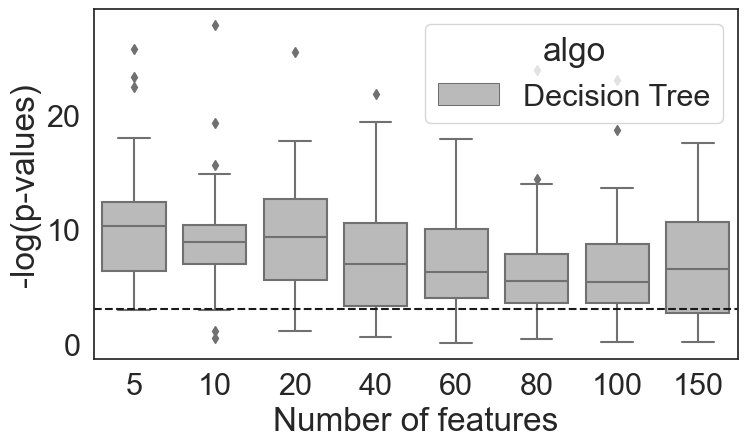

In [17]:
## fig 3b

res["-log(p-values)"] = -np.log(res["Pvalue(Spearman)"].values)
shap_m= res[res.Method=="shap"]
sns.set(style="white", font_scale=2)
fig, ax= plt.subplots(figsize=(8,5))
shap_m["n_features"] = shap_m["n_features"].astype(int)
ax = sns.boxplot(data=shap_m[shap_m.algo=="Decision Tree"], x="n_features", y="-log(p-values)", hue="algo", palette={"Linear Regression":"#dfb920", "Decision Tree":"#BABABA"})
ax.set_xlabel("Number of features")
ax.axhline(-np.log(0.05), c="k", linestyle="--")
plt.savefig(savedir + "Fig3b.svg")
plt.tight_layout()
plt.show()

0.32998712998713
0.5858429858429859


<>:4: SyntaxWarning: invalid escape sequence '\('
<>:4: SyntaxWarning: invalid escape sequence '\('
/var/folders/yn/qvpxfrdd5870gxhq9hf9jvc40000gq/T/ipykernel_48993/3822710068.py:4: SyntaxWarning: invalid escape sequence '\('
  tres["marker_name"] = tres["marker"].str.split("_\(", expand=True)[0].str.split("_",n=1, expand=True)[1]


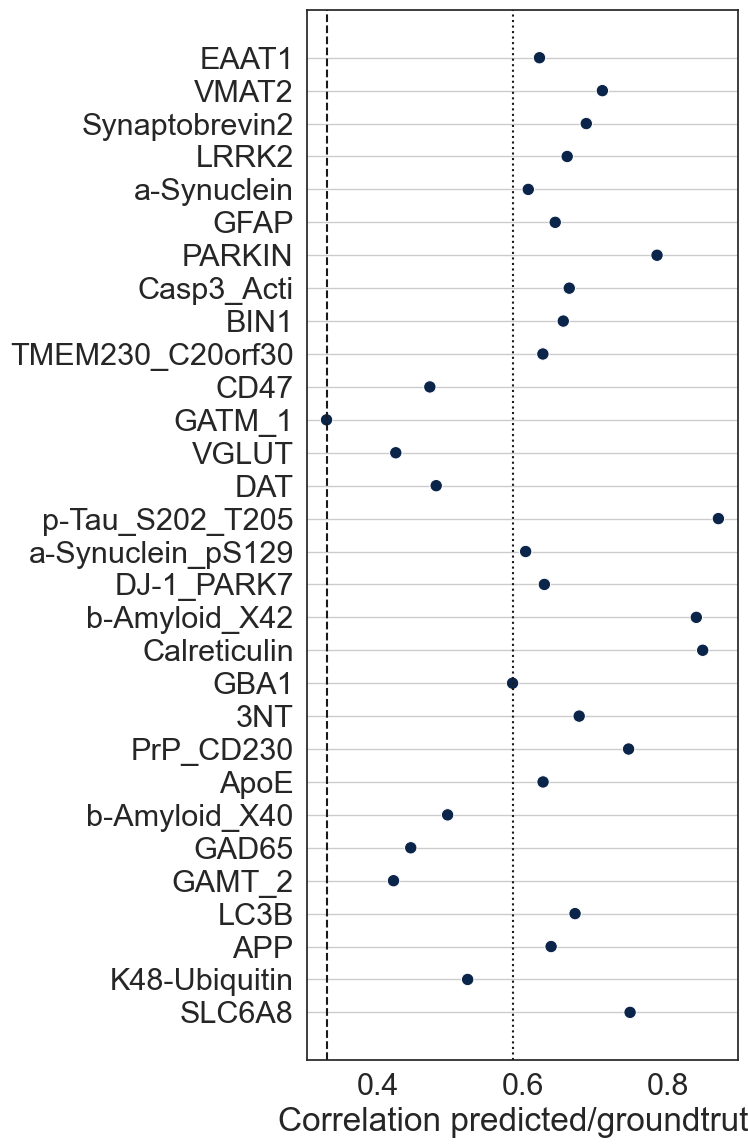

In [18]:
## fig 3A
tres =final
tres["-log(Pvalue)"] = -np.log(tres["Pvalue(Spearman)"]).values
tres["marker_name"] = tres["marker"].str.split("_\(", expand=True)[0].str.split("_",n=1, expand=True)[1]
sns.set(font_scale=2, style="white")

fig, ax = plt.subplots(figsize=(8, 12))
ax.grid(axis='y')

# sns.scatterplot(data=final_no_feat_select, x="Spearman", y="marker_name",size="-log(Pvalue)", ax=ax, color="#ABABAB",style="style", markers=["X"],sizes=(80, 80))
# sns.scatterplot(data=final_no_diet, x="Spearman", y="marker_name",size="-log(Pvalue)", ax=ax, color="#ABABAB",style="style", markers=["s"])
sns.scatterplot(data=tres, x="Spearman", y="marker_name",size="-log(Pvalue)", ax=ax, color="#0b244a",sizes=(80, 80))
tt = tres[tres["Pvalue(Spearman)"]<=0.05].Spearman.min()
print(tres.Spearman.min())
ax.get_legend().remove()
ax.axvline(x=tt, c="k", linestyle="--",label="P>0.05")
tt = tres[tres["Pvalue(Spearman)"]<=0.001].Spearman.min()
print(tt)
ax.axvline(x=tt, c="k", linestyle=":", label="P<=0.001")

ax.set_ylabel("")
ax.set_xlabel("Correlation predicted/groundtruth")

plt.savefig(savedir + "Fig3A.svg")
plt.tight_layout()
plt.show()

In [19]:
if retrain:
    fig, axes = plt.subplots(4,8, figsize=(30, 12))
    axes = axes.flatten()
    for ii,it in enumerate(final.index.tolist()):
        ax= axes[ii]
        pp, pval = spearmanr(y_preds[it].reshape(-1), meta[final.loc[it,"marker"]].values.reshape(-1))
        sns.regplot( x=meta[final.loc[it,"marker"]],y=y_preds[it], ax=ax, color="#0b244a")
        ax.set_xlabel("")#Predicted values")
        ax.set_ylabel("")#Ground truth")
        ax.set_title(it.split("_(")[0].split("_",2)[2])
        ax.text(meta[final.loc[it,"marker"]].min(),np.quantile(y_preds[it], 0.98), "SP: %s (%s)"%(str(np.round(pp,2)), str(np.round(pval, 3))))
        
    # plt.savefig(savedir + "RNA_best_model_with_feature_selection_shap.svg")
    plt.tight_layout()
    plt.show()

In [20]:
final_wight = all_weight_index.loc[final.index.tolist(),:]
final_wight["marker"] = [it.split("_(")[0].split("_",2)[-1] for it in final_wight.index.tolist()]
final_wight.set_index("marker", drop=True, inplace=True)
final_wight.columns = com

In [21]:
meta = adata.obs.join(adata.to_df())

In [22]:
from scipy.stats import pearsonr, spearmanr
import numpy as np


from matplotlib.colors import LinearSegmentedColormap
mycmap = LinearSegmentedColormap.from_list("mycmapd", ["#dfb920", 'white', "#0b244a"], N=256)
hh = meta[com + final["marker"].unique().tolist()]
rho = hh.corr(method="spearman")
feat_corr = rho.loc[final["marker"].unique().tolist(), com]
feat_corr.index = [it.split("_(",1)[0].split("_",1)[-1] for it in feat_corr.index.tolist()]

colss =com
mask = final_wight.loc[feat_corr.index.tolist(), ]
feat_corr =mask.values*feat_corr
feat_corr
to_keep = feat_corr.sum(0)[feat_corr.sum(0)!=0].index.tolist()
feat_corr = feat_corr[to_keep]
if "Diet" in to_keep:
    to_keep.remove("Diet")
    feat_corr.drop("Diet", axis=1, inplace=True)
feat_corr
print(len(to_keep))



148


In [23]:
map_marker = {it.split("_(",1)[0].split("_",1)[-1]: it for it in final["marker"].unique().tolist()}

In [24]:
# ll =feat_corr.stack().reset_index()
# ll = ll[ll[0]!=0]
# pvals_ = []
# for it in ll.iterrows():
#     sp, pv = spearmanr(meta[map_marker[it[1].loc["level_0"]]], meta[it[1].loc["level_1"]])
#     pvals_.append(pv)
# from statsmodels.stats.multitest import multipletests
# ll["pval"] = pvals_
# _, ll["qvalue"],_,_ = multipletests(ll["pval"], method="fdr_bh")

# for ii, it in ll.iterrows():
#     i,j = it["level_0"], it["level_1"]
#     pval = it["pval"]
#     if pval>0.05:
#         feat_corr.loc[i, j] = 0
# feat_corr = feat_corr.loc[:,feat_corr.sum(0)!=0]

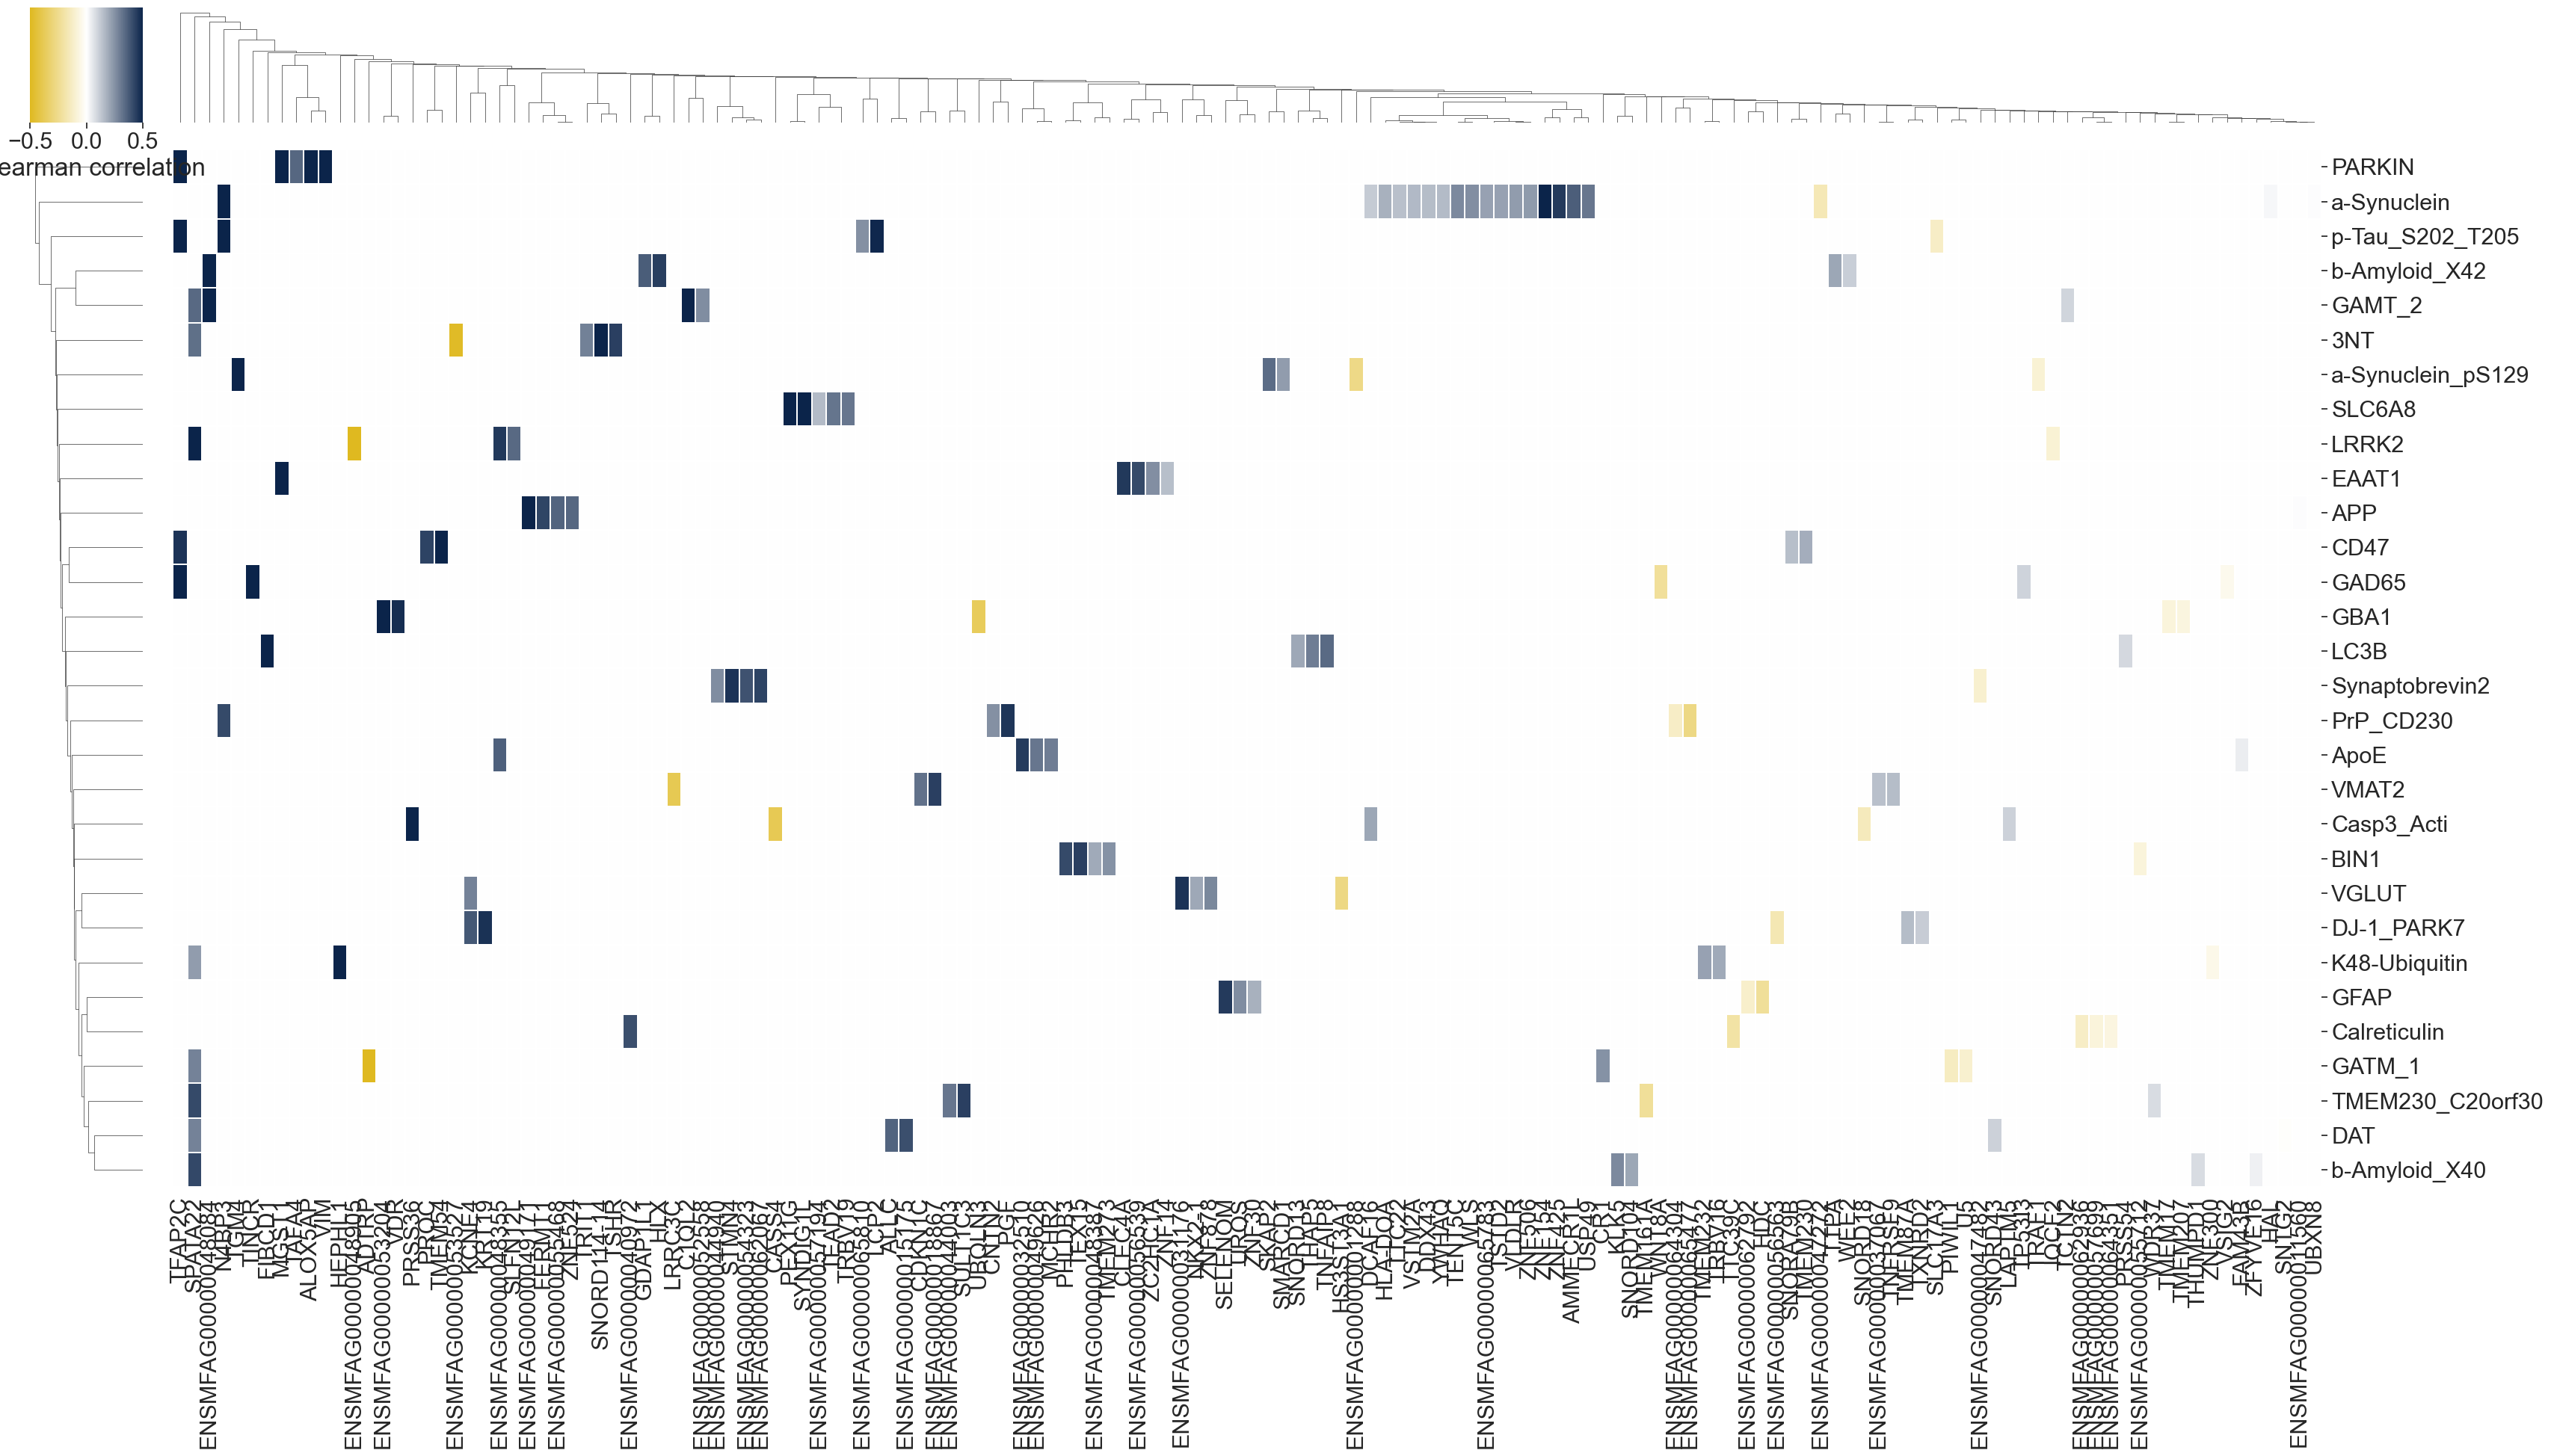

In [25]:
gg = sns.clustermap(feat_corr, figsize=(35, 20),cmap=mycmap, dendrogram_ratio=(0.05,0.1), linewidth=0.2, vmin=-0.5, vmax=0.5,col_cluster=True,
                    xticklabels=True,
                    cbar_kws={"shrink":0.2, "label":"Spearman correlation","orientation":'horizontal' })#, annot=p, fmt="s",)
gg.ax_cbar.set_position([0, 0.95, gg.ax_row_dendrogram.get_position().width, 0.02])

plt.tight_layout()
# plt.savefig(savedir + "tmp.svg")
plt.show()

In [ ]:
##Determin SHAP value

import shap
from mlconfound.stats import partial_confound_test
from mlconfound.plot import plot_null_dist, plot_graph
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold, LeaveOneOut,KFold, RepeatedStratifiedKFold
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
from sklearn.feature_selection import VarianceThreshold, SelectKBest
from sklearn.feature_selection import f_regression
# from causalml.inference.meta import BaseSRegressor, BaseTRegressor#, BaseXRegressor, BaseRRegressor
from sklearn.linear_model import LinearRegression
# from causalml.inference.meta import LRSRegressor

shap_dico = {}
shap_tmp = {}
n_out_splits = 10
outer_cv2 = RepeatedStratifiedKFold(n_splits=n_out_splits,n_repeats=50,  random_state=1)
models = {
                    'Linear Regression':LinearRegression(),
                    #"Logistic Regression":LogisticRegression(),
                    'Decision Tree': DecisionTreeRegressor(random_state=1),
                            #'EN': LogisticRegression(penalty='elasticnet', l1_ratio=0.5, fit_intercept=False, solver='saga', max_iter=10000), #'EN': customLogisticRegressionCV(cv=5, l1_ratios=[0, 0.25, 0.5, 0.75, 1], fit_intercept=False),
                           # 'LASSO': LogisticRegression(penalty='l1', fit_intercept=False, solver='saga', max_iter=10000), #customLogisticRegressionCV(cv=5, l1_ratios=[1], fit_intercept=False), #
                           # 'Ridge': LogisticRegression(penalty='l2', fit_intercept=False), #customLogisticRegressionCV(cv=5, l1_ratios=[0], fit_intercept=False), #
                            'Random Forest': RandomForestRegressor(random_state=1),
                            'KNN': KNeighborsRegressor(),
                            #'SVM': SVC(probability=True),  #rbf for AD, linear for LBD
                            #'XGBoost': XGBClassifier(n_jobs=-1, booster='gblinear', objective='binary:logistic')
                        }
shap_values_per_cv = dict()
cate_per_cv = dict()
mean_ate_per_cv = dict()
for it in final.index.tolist():
    ## Create keys for each sample
    shap_values_per_cv[it] = {} 
    cate_per_cv[it] = {} 
    mean_ate_per_cv[it] = {} 
y_preds = {}
confounding_score = pd.DataFrame(columns=["marker", "model", "P-value"])
for jj,it in final.iterrows():
    y = meta[it["marker"]]
    algo= it["algo"]
    name = jj
           

    w_best = all_weight_index.loc[jj,:]
    feat_index = np.where(w_best>0)[0]

    shap_tmp = {}
    for kj in range(len(X)):
        shap_tmp[kj] = []
    cate_tmp = {}
    for kj in range(len(X)):
        cate_tmp[kj] = []
    tmp = pd.DataFrame(columns=range(len(X)))
    tmp_ate=[]
    for i3, (train_index, test_index) in enumerate(outer_cv2.split(X,meta["Diet"])):
                    X_train, X_test = X[train_index, :], X[test_index, :]
                    y_train, y_test = y[train_index], y[test_index]
                    clf = models[algo]
                    scaler = StandardScaler()
                    pipe = Pipeline([("scale", scaler),
                                #("featureselection" , VarianceThreshold()),
                                             #("featureSelection", ReliefF(),# SelectKBest(f_regression, k=int(best_k))),
                                      #("reduce_dims", PCA()),
                                     ("model", clf)
                                     ])
                    pipe.fit(np.array(X_train[:,feat_index]), np.array(y_train))
                    clf2 = models[algo]
                    scaler2 = StandardScaler()
                    pipe2 = Pipeline([("scale", scaler2),
                                #("featureselection" , VarianceThreshold()),
                                             #("featureSelection", ReliefF(),# SelectKBest(f_regression, k=int(best_k))),
                                      #("reduce_dims", PCA()),
                                     ("model", clf2)
                                     ])
                    # learner_s = BaseSRegressor(learner=pipe2)
                    treat =  meta.iloc[train_index,:]["Diet"].map({"mediterranean":0, "western":1}).astype(int).values
                    treat[treat==2] = 0
                    feat_index_t = feat_index
                    if 0 in feat_index_t:
                        feat_index_t = feat_index_t[1:]
                    # learner_s.fit(X=np.array(X_train[:,feat_index_t]), treatment=treat, y=np.array(y_train))
                    y_pred = np.array(pipe.predict(np.array(X_test[:, feat_index])))
                    # y_preds[name].loc[test_index, :] = y_pred.reshape((-1,1))#[0]
                    ans_list = [None] * len(X)
                    start = 0
                    for j in test_index:

                        ans_list[j] = y_pred[start]
                        start += 1
                        tmp.loc[len(tmp),:]=ans_list
                    # Use SHAP to explain predictions
                    X_std = scaler.transform(np.array(X_test[:, feat_index]))
                    if algo =="Linear Regression":
                        explainer = shap.explainers.Linear(clf, X_std)
                        shap_values = explainer(X_std).values
                    else:
                        explainer = shap.TreeExplainer(clf)
                        shap_values = explainer.shap_values(X_std)
                        
                    w_ = np.abs(shap_values).mean(0)
                    # shap_tmp.loc[len(tmp_shap), feat_index] = w_
                    for lk, ti in enumerate(test_index):
                        shap_tmp[ti].append(shap_values[lk])
                    treat = meta.iloc[test_index,:]["Diet"].map({"mediterranean":0, "western":1}).astype(int).values
                    treat[treat==2] = 0
                    # ate_s = 0#learner_s.estimate_ate(X=np.array(X_test[:, feat_index_t]), treatment=treat, y=np.array(y_test), return_ci=True, pretrain=True)
                    # print(ate_s)
                    # tmp_ate.append(ate_s)
                    # cate_s = learner_s.predict(X=np.array(X_test[:, feat_index_t]), treatment=treat, y=np.array(y_test))
                    # for lk, ti in enumerate(test_index):
                    #     cate_tmp[ti].append(cate_s[lk])
                    # print(cate_s)
    # shap_dico[jj] = tmp_shap
   
    shap_values_per_cv[jj] = shap_tmp
    # mean_ate_per_cv[jj] = np.mean(tmp_ate)
    # cate_per_cv[jj] = cate_tmp
    y_preds[jj] = tmp.mean(0).values.astype(float).reshape(-1)
    pearson, pearsonp = pearsonr(y, y_preds[name].astype(float).reshape(-1))
    print(jj)
    print(pearson)
    zz =partial_confound_test(y, y_preds[jj], X[:,0])
 
    confounding_score.loc[len(confounding_score),:] = [it["marker"], jj, zz.p]
    
                                 

In [27]:
# sns.set(style="white")
# confounding_score["markers"] = confounding_score["marker"].apply(lambda x: x.split("_(")[0].split("_",1)[1])
# confounding_score["-log(P-value)"] = -np.log(confounding_score["P-value"].astype(float).values)
# confounding_score = confounding_score.sort_values("-log(P-value)")
# # Stem plot
# fig, ax = plt.subplots(figsize=(5,12))
# ax.grid(axis='y')
# x=confounding_score["markers"]
# y=confounding_score["-log(P-value)"]
# ax.stem(x, y, bottom = -np.log(0.05),orientation='horizontal',linefmt="k--", markerfmt="k",basefmt="#dfb920")
# ax.tick_params(labelsize=20)
# ax.set_xlabel("Diet confounding -log(P-values)", fontsize=20)
# # plt.savefig(savedir + "RNA_counfounding_score_model_phenotype_pvalues.svg")
# plt.show()

/var/folders/yn/qvpxfrdd5870gxhq9hf9jvc40000gq/T/ipykernel_48993/944997495.py:28: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  plt.register_cmap(cmap=mycmap)


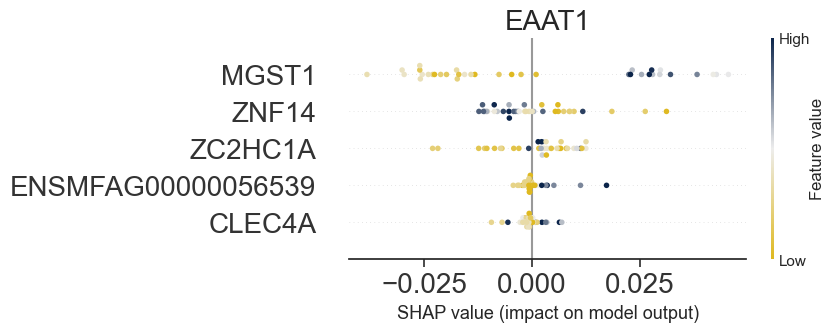

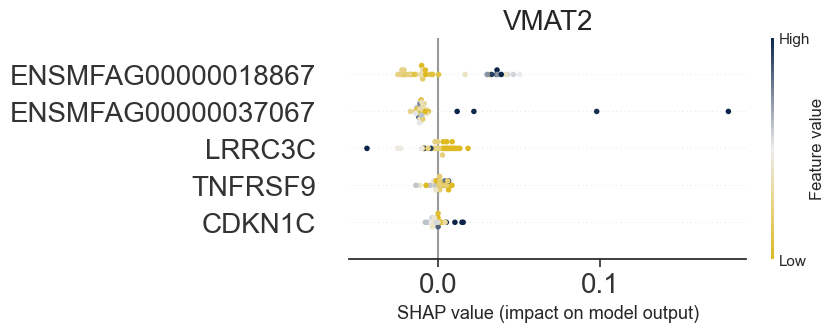

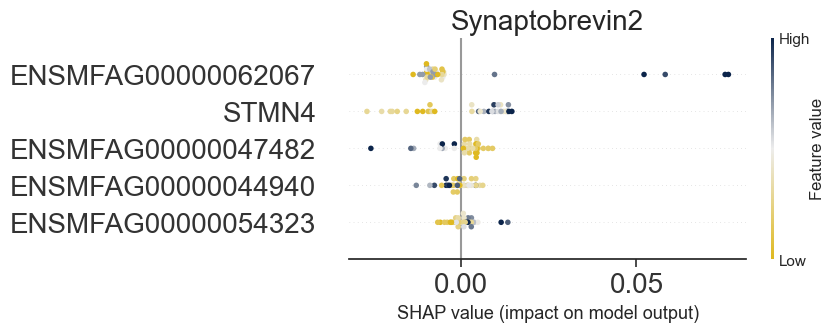

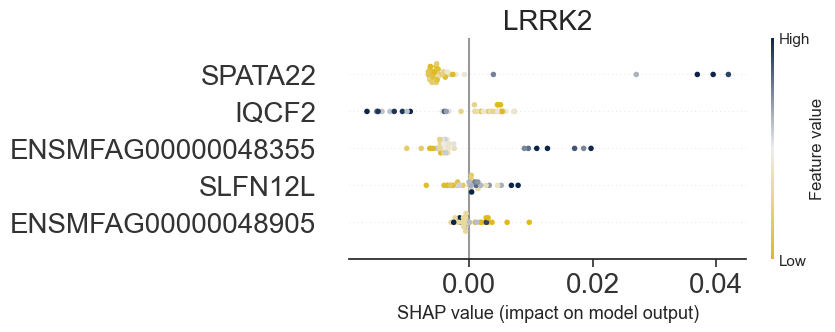

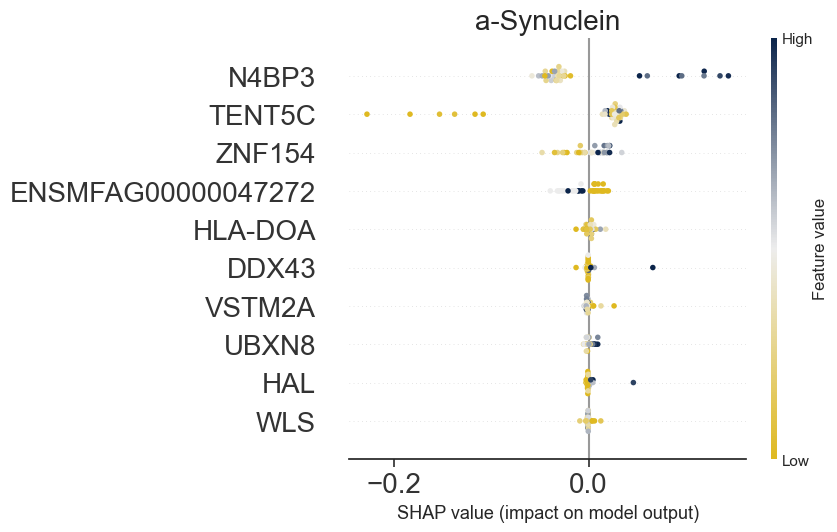

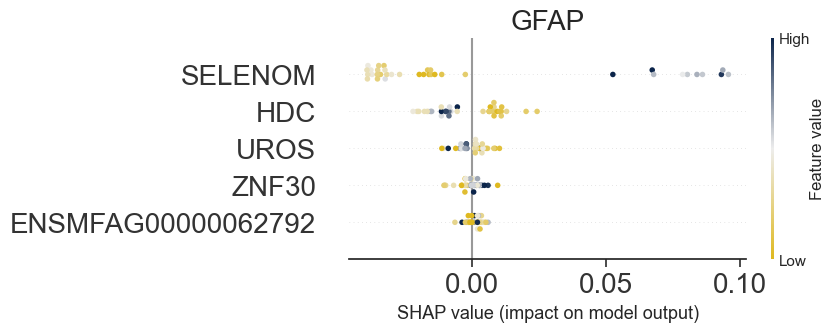

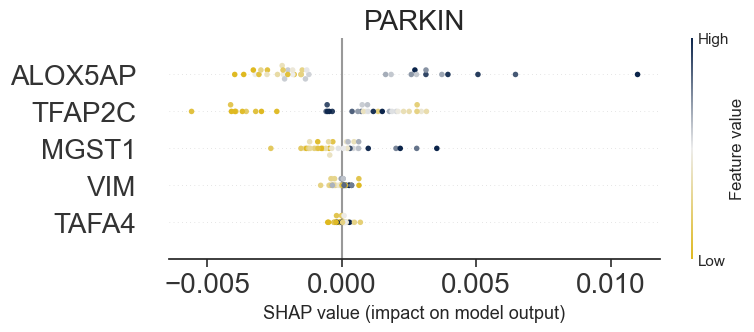

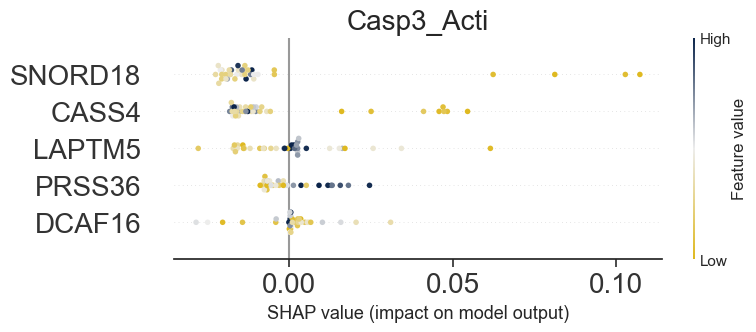

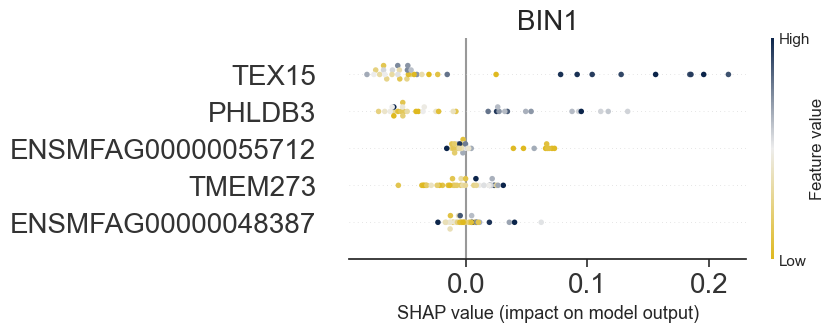

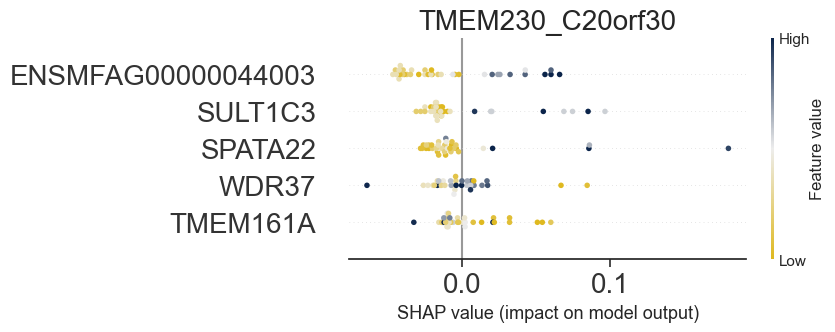

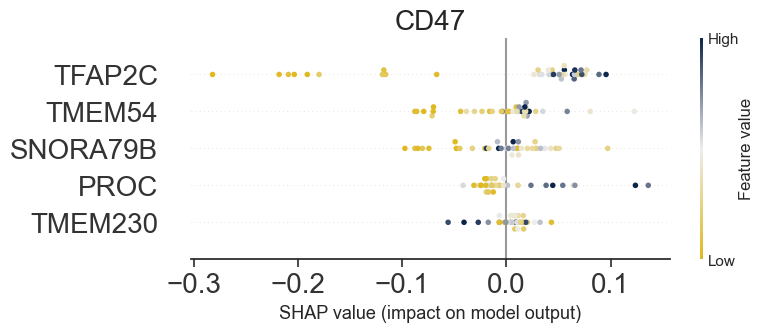

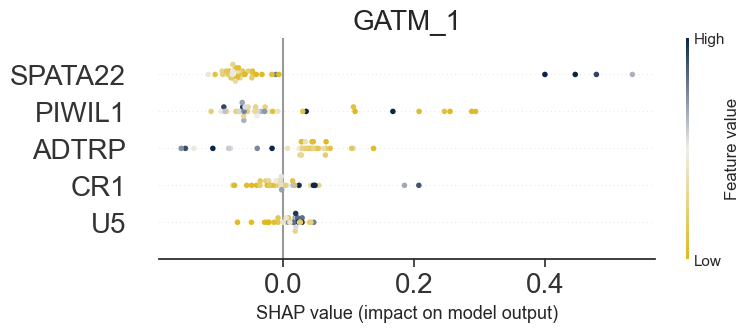

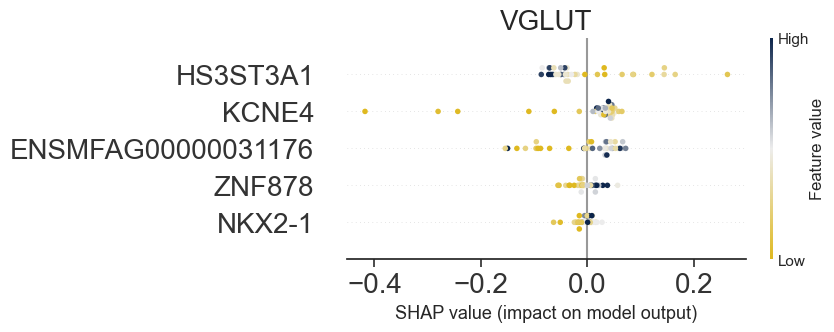

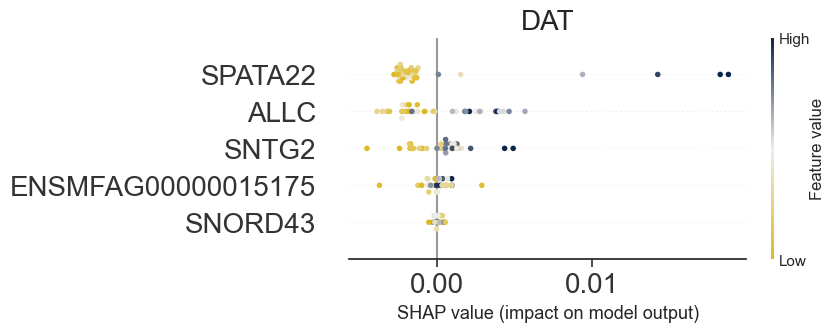

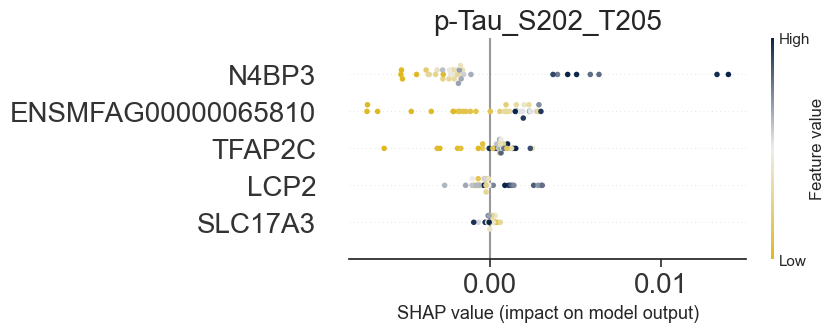

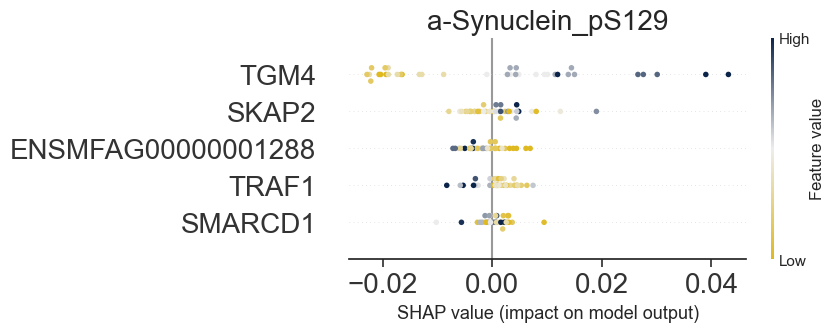

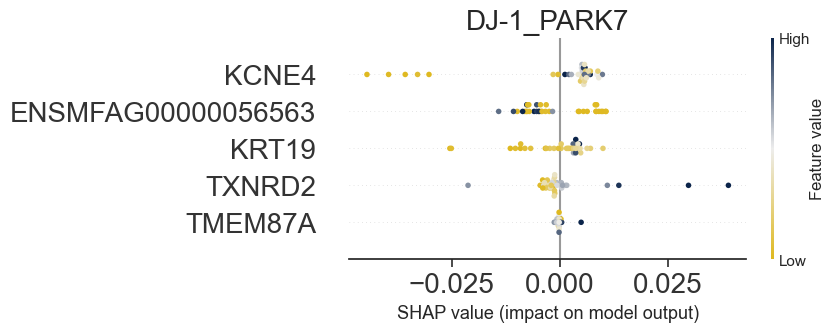

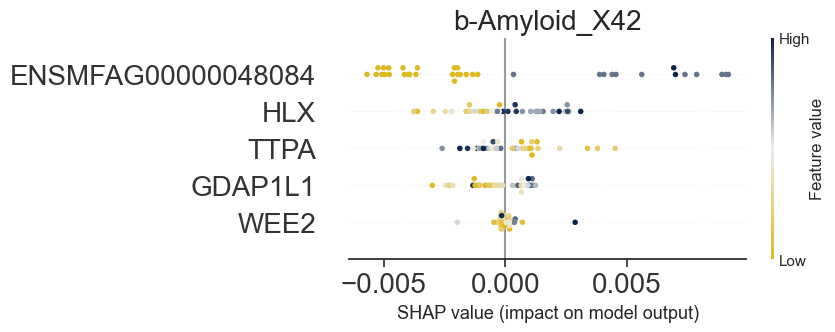

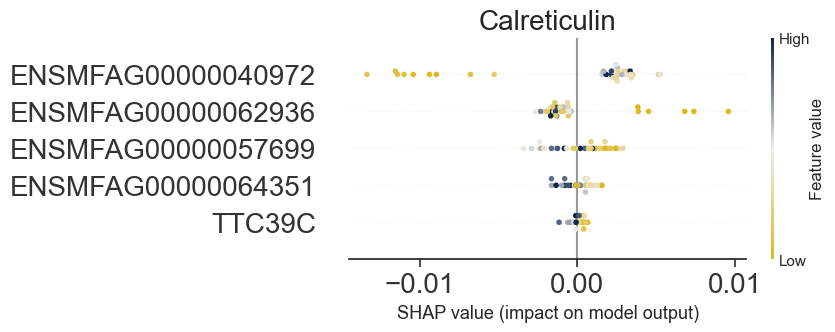

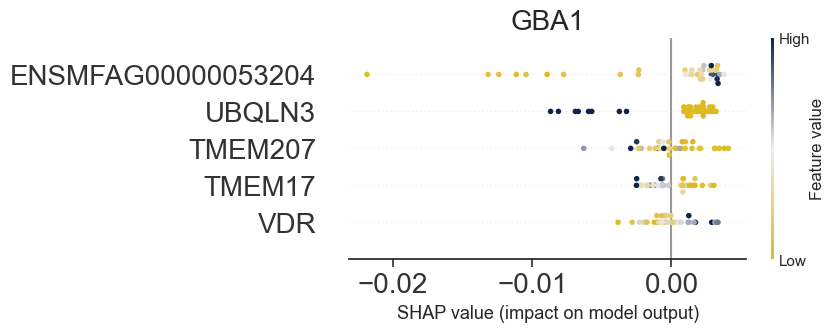

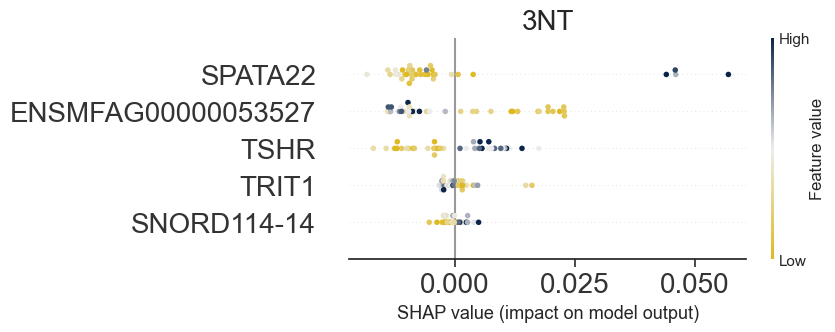

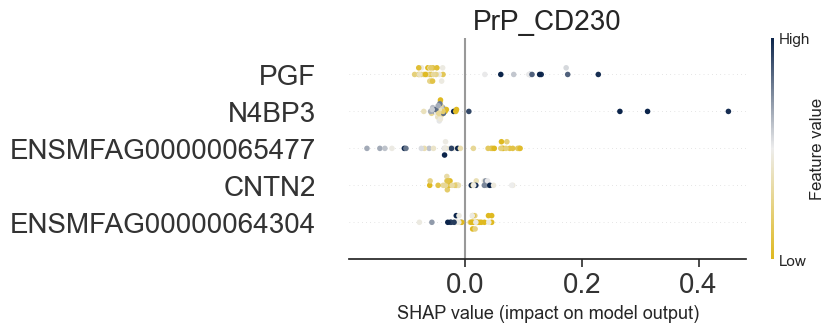

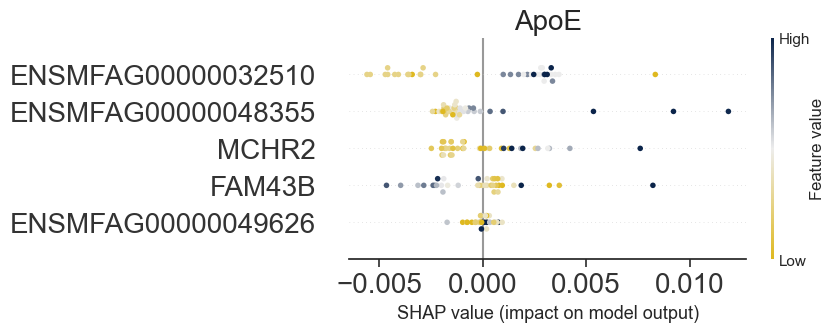

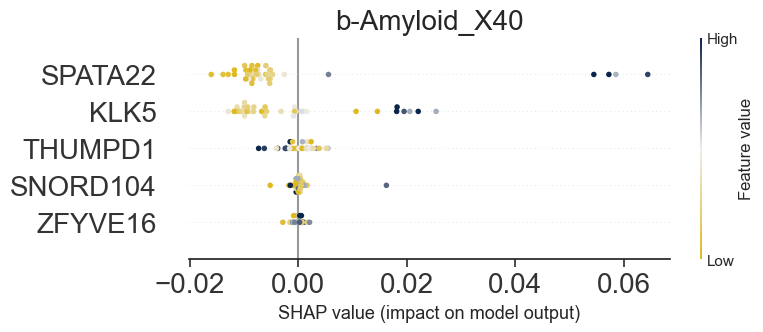

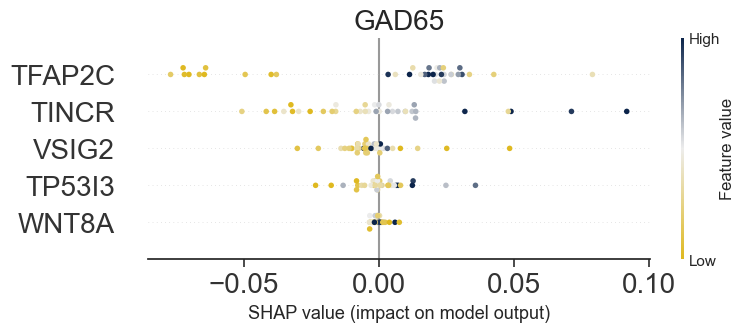

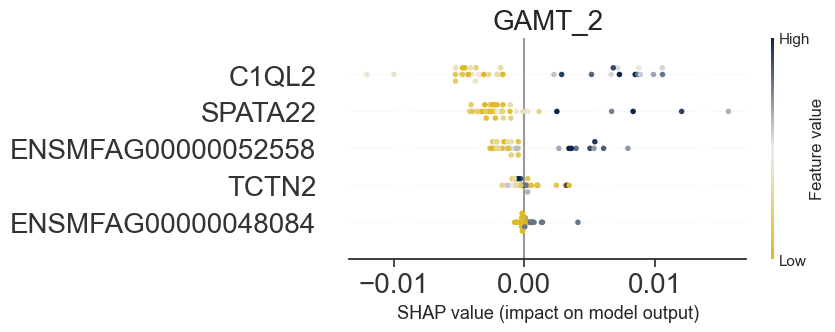

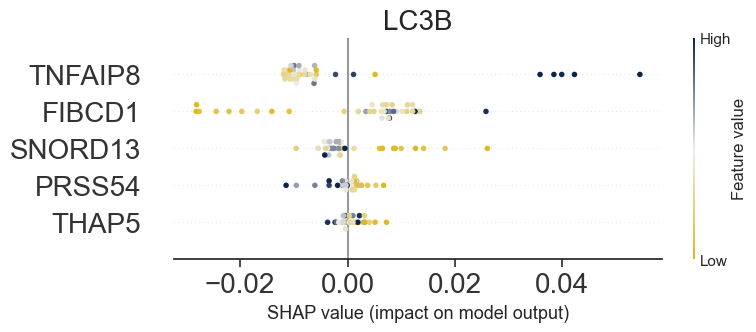

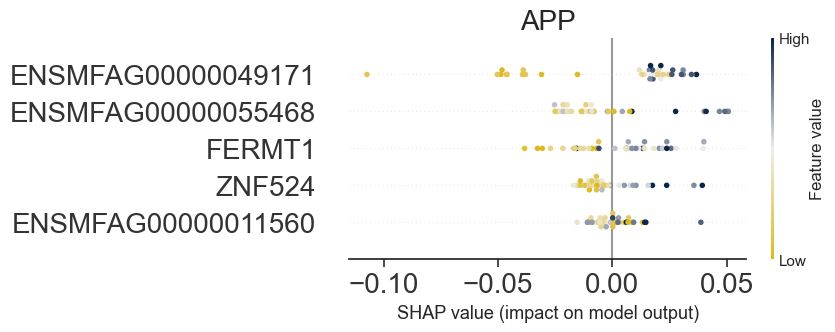

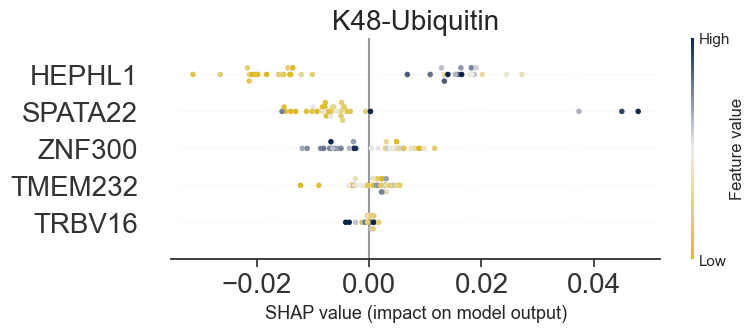

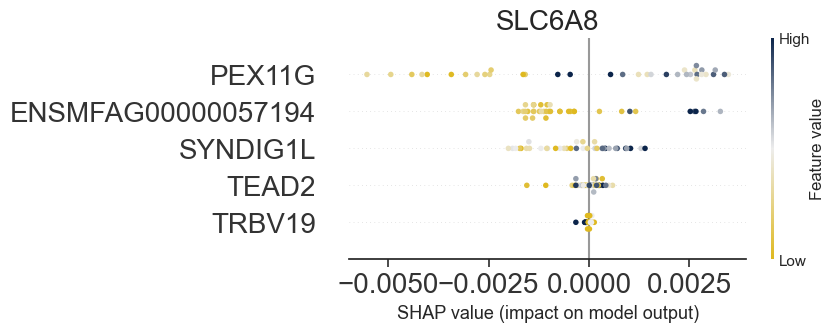

In [28]:
shap_mean_val ={}
shap_std_val ={}
shap_range_val ={}
for it in shap_values_per_cv.keys():
    # Establish lists to keep average Shap values, their Stds, and their min and max
    average_shap_values, stds, ranges = [],[],[]
    shap_dico = shap_values_per_cv[it]
    for i in range(0,len(X)):
        df_per_obs = pd.DataFrame.from_dict(shap_dico[i]) # Get all SHAP values for sample number i
        # Get relevant statistics for every sample 
        average_shap_values.append(df_per_obs.mean(axis=0).values) 
        stds.append(df_per_obs.std(axis=0).values)
        ranges.append(df_per_obs.max(axis=0).values-df_per_obs.min(axis=0).values)
    shap_mean_val[it] = np.array(average_shap_values)
    shap_std_val[it] = np.array(stds)
    shap_range_val[it] = np.array(ranges)



fig_savedir = savedir + "feat_importance_with_feat_selection"
if not os.path.exists(fig_savedir):
    os.mkdir(fig_savedir)


import shap
from matplotlib.colors import LinearSegmentedColormap
mycmap = LinearSegmentedColormap.from_list("mycmapd", ["#dfb920", '#EDEDED', "#0b244a"], N=256)
plt.register_cmap(cmap=mycmap)
for it in shap_mean_val.keys():
    plt.figure()
    xx =  meta[com].iloc[:,np.where(all_weight_index.loc[it]==1)[0]]
   
    shap.summary_plot(shap_mean_val[it],xx, show = False,max_display=10)#, plot_type="bar")
    # plt.title('%s: Average SHAP values after 10x cross-validation'%it.split("_(")[0].split("_",2)[-1])
    plt.title(it.split("_(")[0].split("_",2)[-1],fontsize=20)

    # Change the colormap of the artists
    plt.set_cmap(mycmap)
    for fc in plt.gcf().get_children():
        for fcc in fc.get_children():
            if hasattr(fcc, "set_cmap"):
                fcc.set_cmap(mycmap)
  
#                 # fcc.tick_params(labelsize=20)
    plt.tick_params(labelsize=20)
    # plt.xlabel("SHAP value (impact on model output)",fontsize=20)
    # plt.savefig(os.path.join(fig_savedir, "shap_value_feat_70_with_diet_%s.svg"%it))
    plt.show()

/var/folders/yn/qvpxfrdd5870gxhq9hf9jvc40000gq/T/ipykernel_48993/1624821562.py:25: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


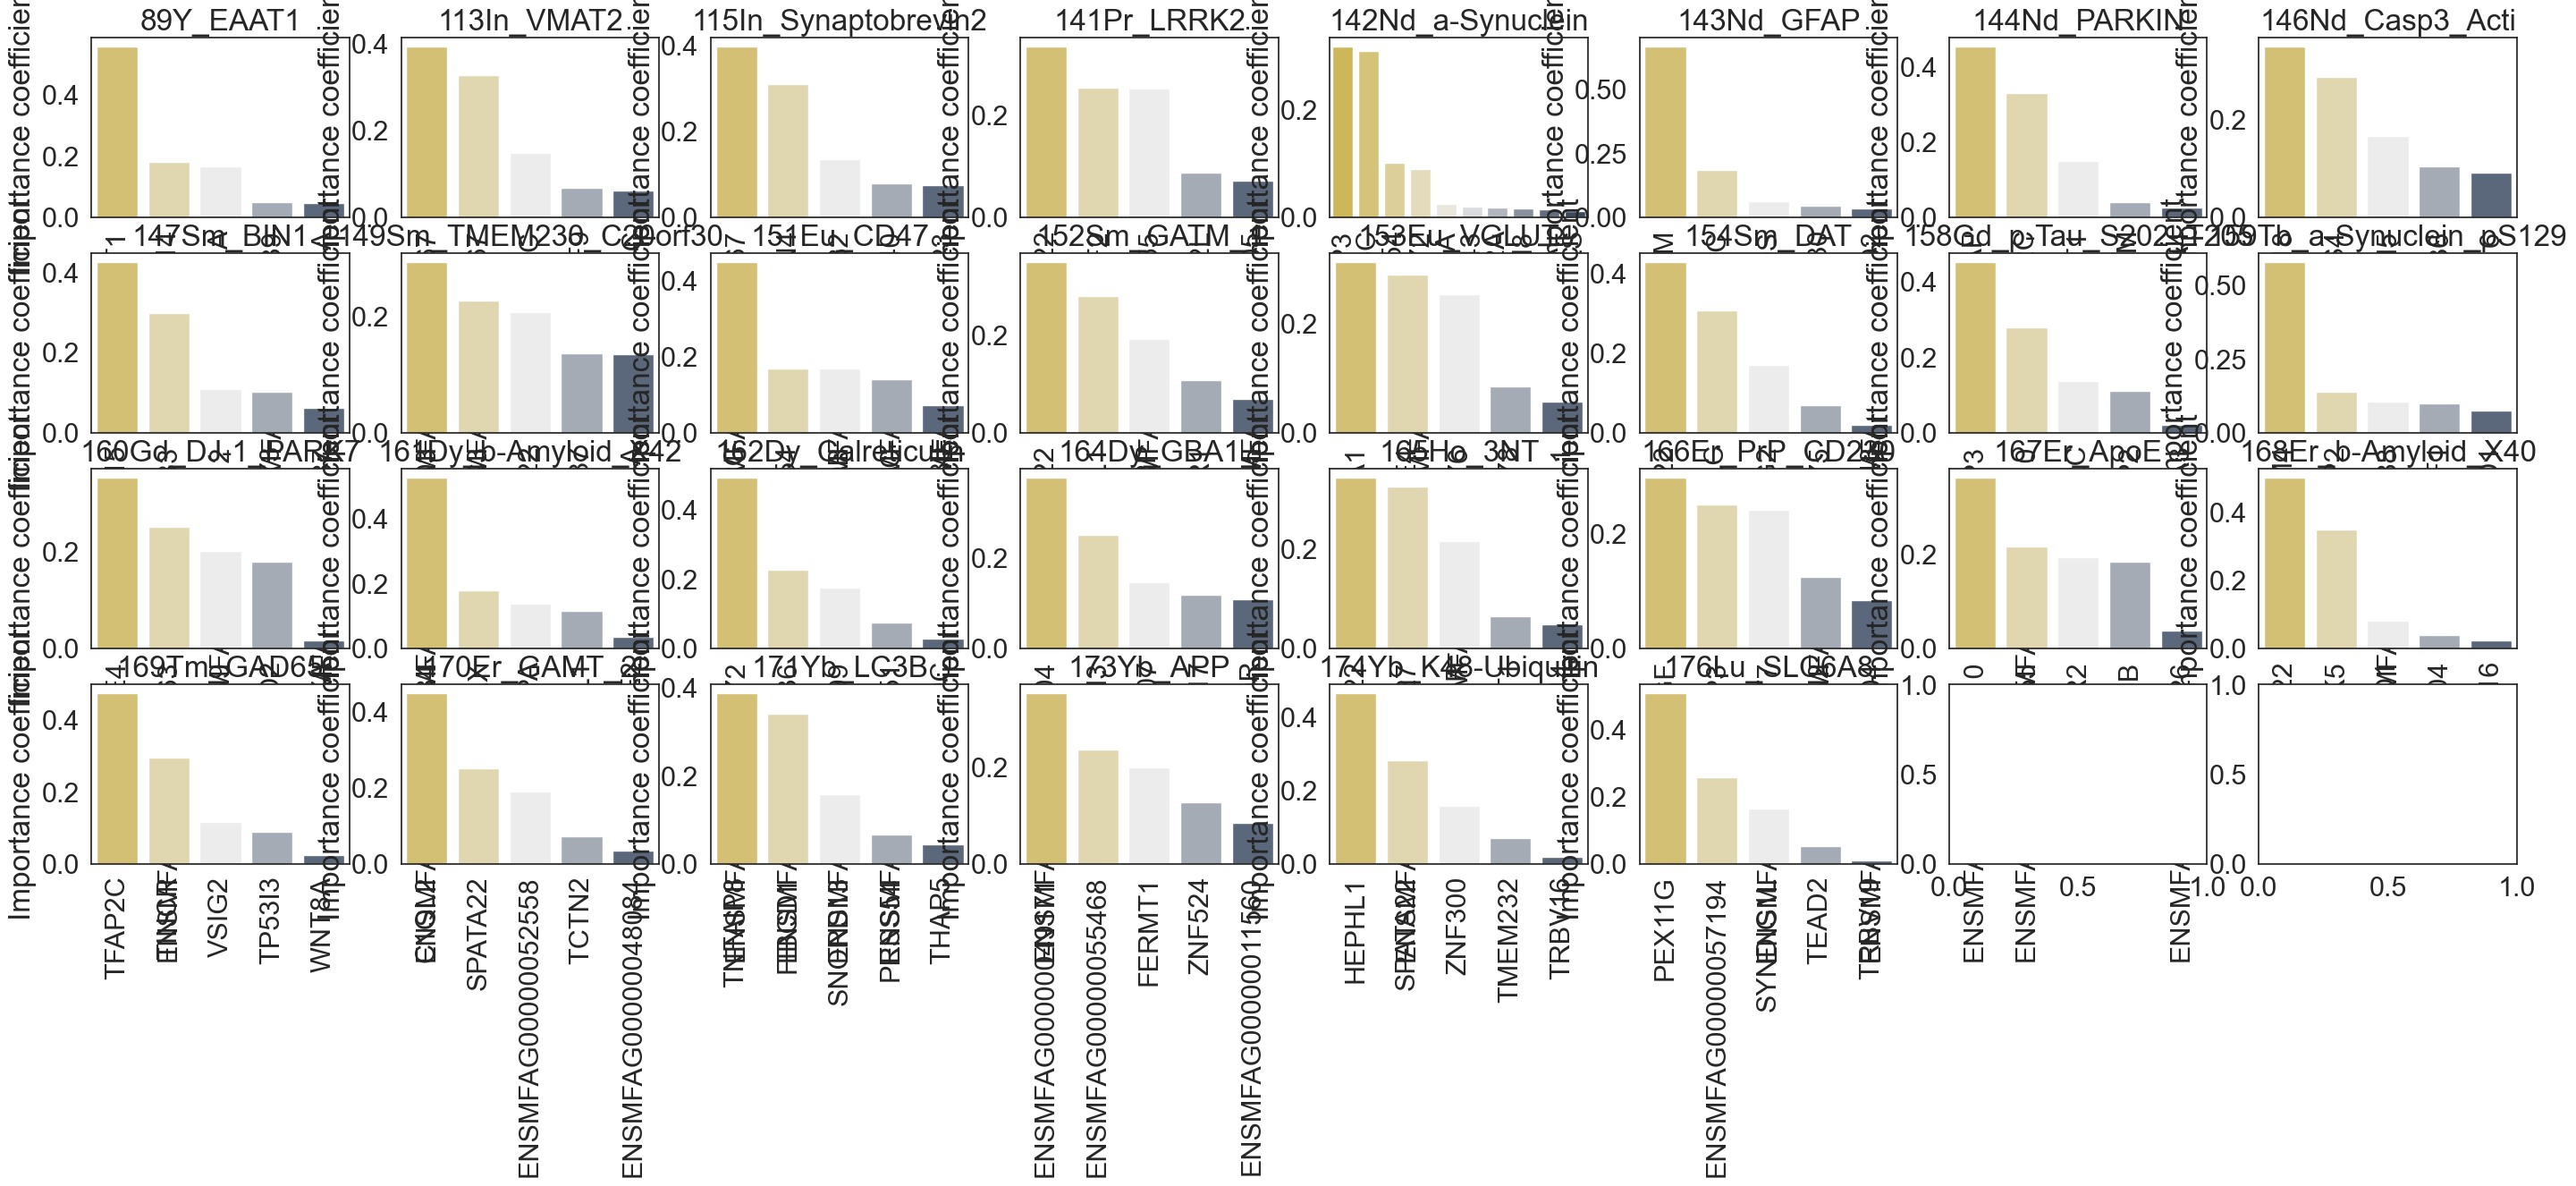

In [29]:
wt = shap_mean_val
#fig, axes = plt.subplots(1,len(final), figsize=(20, 12))
sns.set(style="white", font_scale=2)
fig, axes = plt.subplots(4,8, figsize=(35, 12))

axes = axes.flatten()

for ii,it in enumerate(final.index.tolist()):
    ax= axes[ii]
    my_cmap = plt.get_cmap("Blues")
    rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
    xx =  meta[com].iloc[:,np.where(all_weight_index.loc[it]==1)[0]]
    feat_importances = pd.DataFrame(np.abs(wt[it]).mean(0)/ (np.abs(wt[it]).mean(0).sum()), index=xx.columns, columns=["Importance"])
    feat_importances.sort_values(by='Importance', ascending=False, inplace=True, )
    # y = feat_importances["Importance"][:20]#.values()
    data = feat_importances[:10].reset_index()
    sns.barplot(data=data,x="index", y="Importance", 
                ax=ax, palette="mycmapd")
    ax.set_title(it.split("_(")[0].split("_",1)[1])
    ax.set_ylabel("Importance coefficient")
    xla = [it.get_text() for it in ax.get_xticklabels()]
    ax.set_xticklabels(xla, rotation=90)
    ax.set_xlabel("")
   # ax.get_legend().remove()
plt.tight_layout()
# plt.savefig(savedir + "best_åçmodel_20_features_importance_70_no_selection.svg")
plt.show()

/var/folders/yn/qvpxfrdd5870gxhq9hf9jvc40000gq/T/ipykernel_48993/320222583.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  feat_importance.fillna(0, inplace=True)
/var/folders/yn/qvpxfrdd5870gxhq9hf9jvc40000gq/T/ipykernel_48993/320222583.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_plot.fillna(0, inplace=True)


(4440, 3)

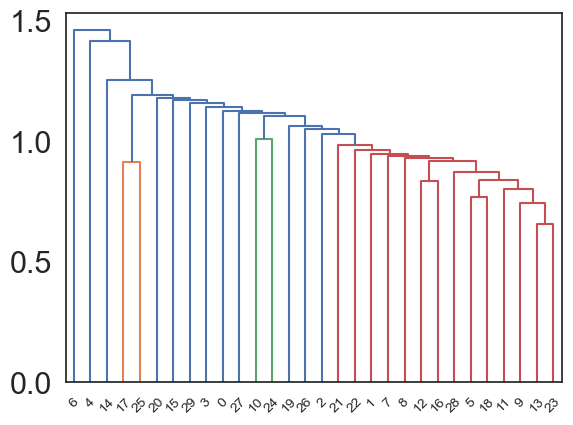

In [30]:
feat_importance = pd.DataFrame(columns=meta[com].columns.tolist())
n_features = 30
for ii,it in enumerate(final.index.tolist()):
    marker = it.split("_(")[0].split("_",2)[-1]
    w_best = np.abs(wt[it]).mean(0)/ (np.abs(wt[it]).mean(0).sum()).tolist()
    #indx = sorted(range(len(w_best)), key=lambda i: w_best[i])[-n_features:]
    #no_sel = [it for it in range(len(w_best)) if not it in indx]
    #w_best[no_sel] = 0
    xx =  meta[com].iloc[:,np.where(all_weight_index.loc[it]==1)[0]]
    feat_importance.loc[marker, xx.columns.tolist()] = w_best
feat_importance[feat_importance<= 0.001] = 0
feat_importance.fillna(0, inplace=True)
to_plot = feat_importance.loc[:,feat_importance.sum(0) !=0]

to_plot.fillna(0, inplace=True)

to_plot = to_plot.stack().reset_index(name="mean(|SHAP value|)")

from scipy.stats import pearsonr, spearmanr
import numpy as np
from scipy.spatial import distance
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram
from matplotlib.colors import LinearSegmentedColormap
mycmap = LinearSegmentedColormap.from_list("mycmapd", ["#dfb920", 'white', "#0b244a"], N=256)
hh = meta[com + final["marker"].unique().tolist()]
rho = hh.corr(method="spearman")
feat_corr = rho.loc[final["marker"].unique().tolist(), com]
feat_corr.index = [it.split("_(",1)[0].split("_",1)[-1] for it in feat_corr.index.tolist()]
mask = final_wight.loc[feat_corr.index.tolist(), ]
feat_corr =mask.values*feat_corr
to_keep = feat_corr.sum(0)[feat_corr.sum(0)!=0].index.tolist()
feat_corr = feat_corr[to_keep]
if "Diet" in to_keep:
    to_keep.remove("Diet")
    feat_corr.drop("Diet", axis=1, inplace=True)
row_linkage = hierarchy.linkage(
    distance.pdist(feat_corr.values), method='average')
dn = dendrogram(row_linkage)
list_rows = feat_corr.index.tolist()
feat_corr = feat_corr.stack().reset_index(name="Spearman Correlation")
feat_corr.shape

In [31]:
to_plot = to_plot.merge(feat_corr, on=["level_0","level_1"], how="left")

order_row = np.asarray(list_rows)[np.asarray(dn["leaves"]).astype(int)]
order_row

sorterIndex = dict(zip(order_row, range(len(order_row))))
to_plot['order_row'] = to_plot['level_0'].map(sorterIndex)
to_plot = to_plot.sort_values([ "order_row"])


to_plot=to_plot[(to_plot["mean(|SHAP value|)"]!=0)&(to_plot["Spearman Correlation"] !=0)]


In [32]:
to_plot = to_plot[to_plot["mean(|SHAP value|)"]>0.1]
to_plot=to_plot[to_plot["mean(|SHAP value|)"]+to_plot["Spearman Correlation"] !=0]
to_plot

,level_0,level_1,mean(|SHAP value|),Spearman Correlation,order_row
985,PARKIN,TFAP2C,0.329246,0.539427,0
890,PARKIN,ALOX5AP,0.453476,0.660529,0
954,PARKIN,MGST1,0.150106,0.662333,0
659,a-Synuclein,N4BP3,0.317315,0.504377,1
733,a-Synuclein,ZNF154,0.101257,0.498906,1
...,...,...,...,...,...
2011,DAT,SNTG2,0.171819,-0.009782,28
2012,DAT,SPATA22,0.429951,0.284335,28
1925,DAT,ALLC,0.307383,0.355433,28
3492,b-Amyloid_X40,SPATA22,0.501800,0.414468,29


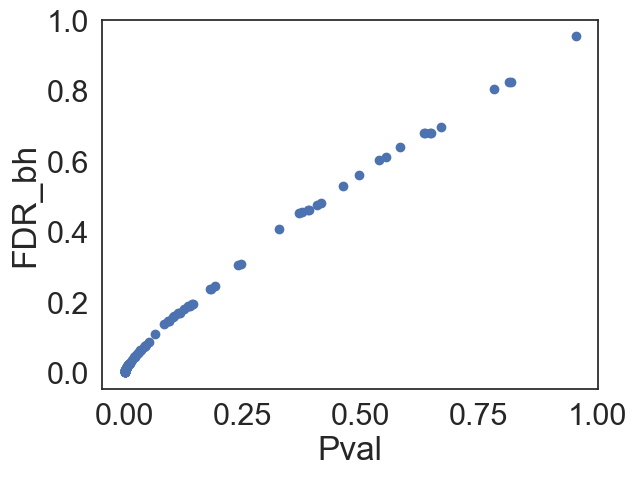

In [33]:
ll = to_plot #ll[ll[0]!=0]
pvals_ = []
for it in ll.iterrows():
    sp, pv = spearmanr(meta[map_marker[it[1].loc["level_0"]]], meta[it[1].loc["level_1"]])
    pvals_.append(pv)
ll["pval"] = pvals_
ll


to_plot["pval"].values
from statsmodels.stats.multitest import multipletests
qvalue  =multipletests(to_plot["pval"].values, method="fdr_bh")[1]
to_plot["Adjusted Pvalue"] = qvalue
to_plot
plt.scatter(to_plot["pval"].values,qvalue, label="FDR_bh" )
# plt.scatter(to_plot["pval"].values,qvalue2,label="Bonferroni",c="g"
           # )
# plt.plot(to_plot["pval"].values,to_plot["pval"].values)
plt.xlabel("Pval")
plt.ylabel("FDR_bh")
plt.show()

In [40]:
to_plot.rename(columns={"level_0":"SynTOF markers", "level_1":"Transcriptomic Markers",
                "pval":"Raw P-value", "Adjusted Pvalue":"Adjusted P-value"},inplace=True)
to_plot.drop(["order_row"],axis=1).to_csv(savedir + "Supp Table4.csv", index=None)
to_plot

/var/folders/yn/qvpxfrdd5870gxhq9hf9jvc40000gq/T/ipykernel_48993/2329747484.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_plot.rename(columns={"level_0":"SynTOF markers", "level_1":"Transcriptomic Markers",


,SynTOF markers,Transcriptomic Markers,mean(|SHAP value|),Spearman Correlation,order_row,Row P-value,Adjusted P-value
985,PARKIN,TFAP2C,0.329246,0.539427,0,6.863051e-04,0.004375
890,PARKIN,ALOX5AP,0.453476,0.660529,0,1.165466e-05,0.000297
954,PARKIN,MGST1,0.150106,0.662333,0,1.081729e-05,0.000297
659,a-Synuclein,N4BP3,0.317315,0.504377,1,1.708535e-03,0.008299
733,a-Synuclein,ZNF154,0.101257,0.498906,1,1.953158e-03,0.008662
2139,p-Tau_S202_T205,N4BP3,0.451584,0.612384,2,7.202775e-05,0.001050
2135,p-Tau_S202_T205,LCP2,0.110478,0.492017,2,2.304476e-03,0.009794
2169,p-Tau_S202_T205,TFAP2C,0.137071,0.588349,2,1.606824e-04,0.001821
2572,b-Amyloid_X42,HLX,0.180833,0.440231,3,7.211337e-03,0.020865
2540,b-Amyloid_X42,ENSMFAG00000048084,0.527431,0.697645,3,2.257426e-06,0.000115


In [35]:
to_plot = to_plot[to_plot["Adjusted Pvalue"]<=0.05]

/var/folders/yn/qvpxfrdd5870gxhq9hf9jvc40000gq/T/ipykernel_48993/4210097640.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.ax.set_xticklabels(g.ax.get_xticklabels(), rotation=90)


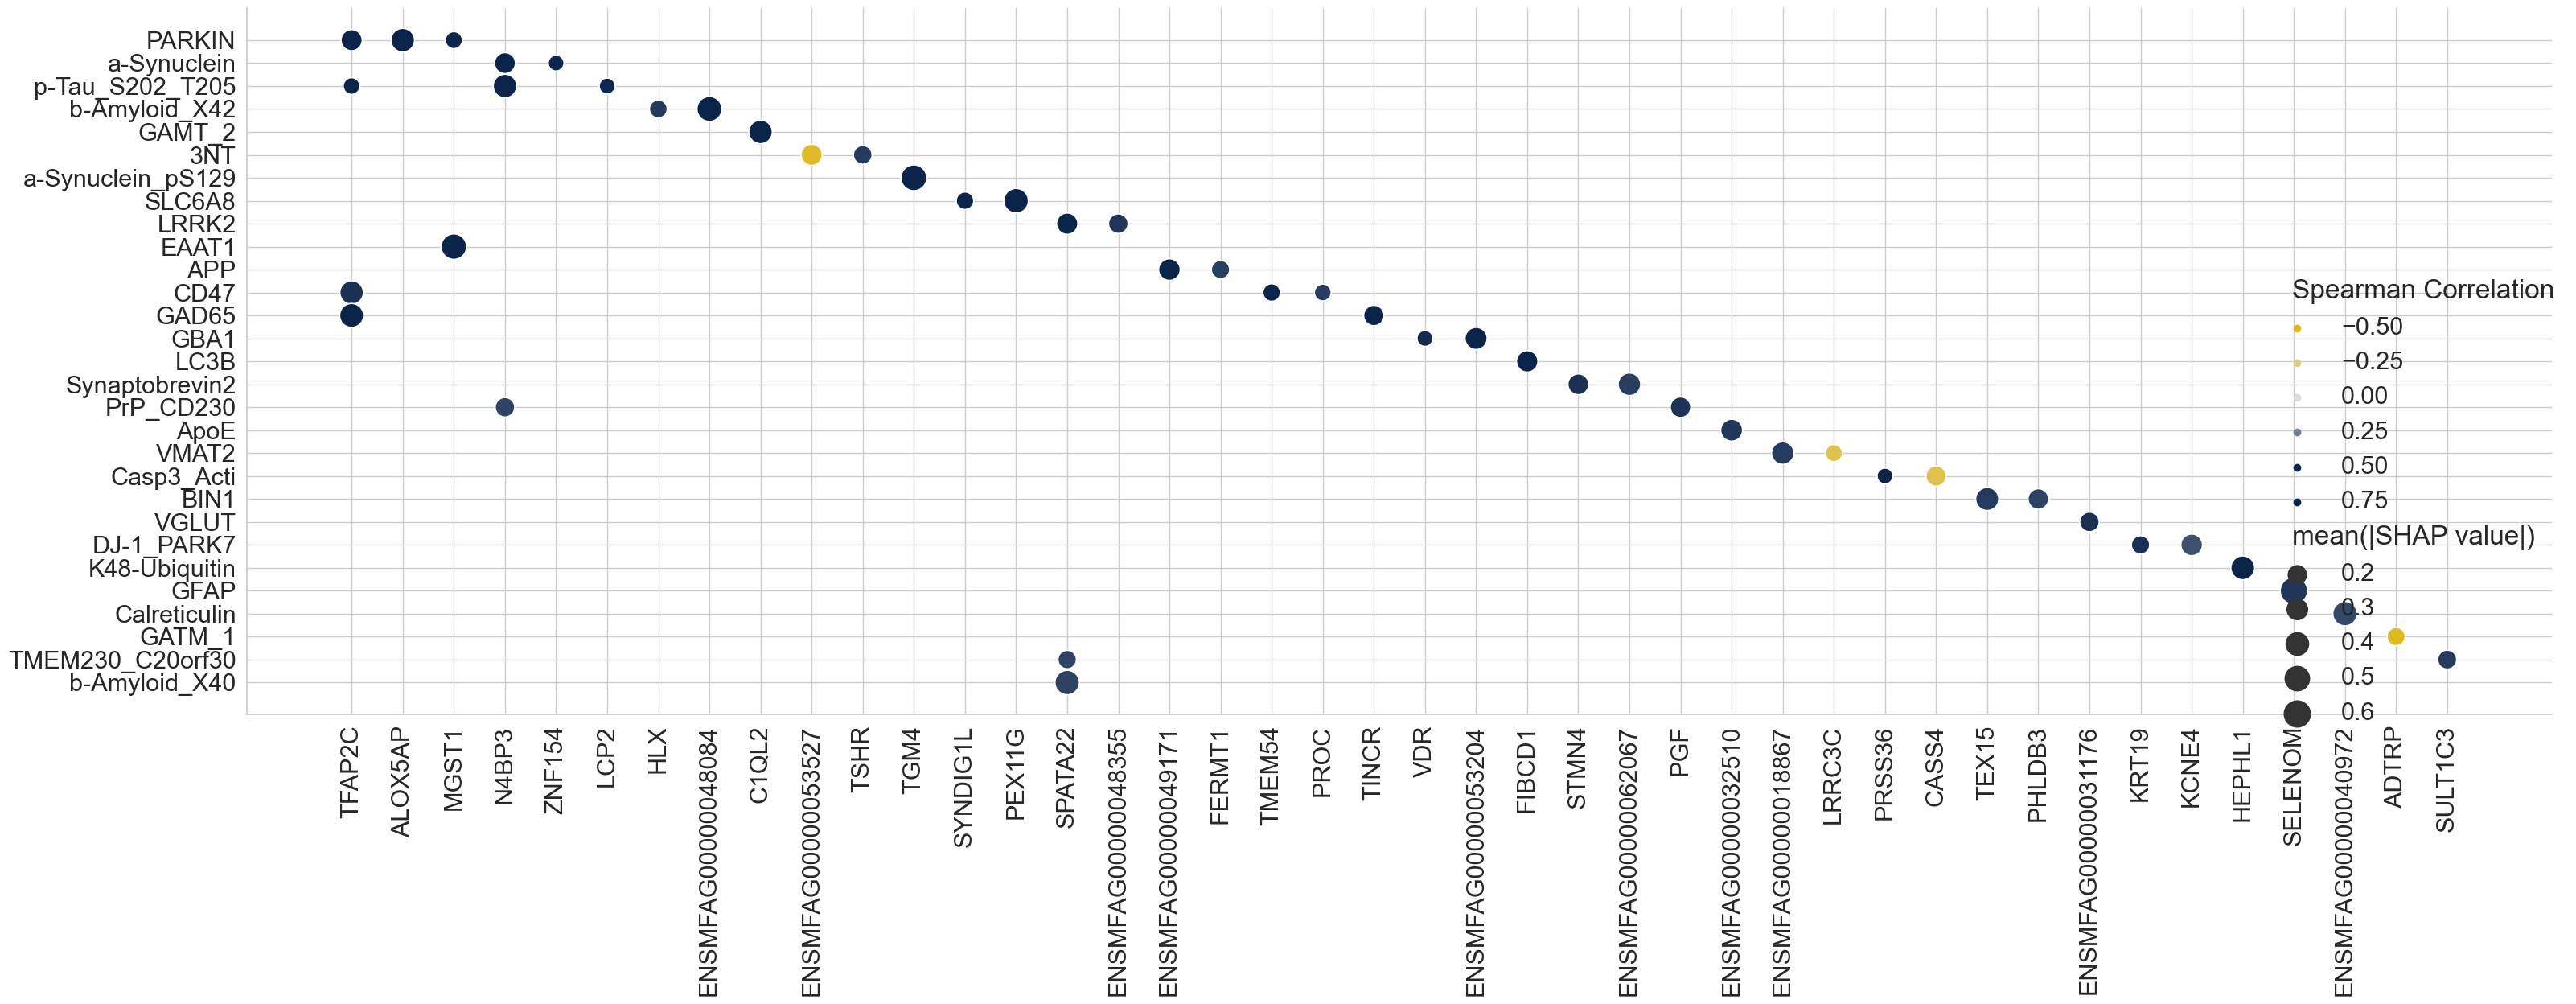

In [36]:
mycmap2 = LinearSegmentedColormap.from_list("mycmapd", ["#dfb920", '#DEDEDE', "#0b244a"], N=256)
# plt.register_cmap(cmap=mycmap)
sns.set(style="whitegrid",font_scale=2)
# to_plot["level_1"] = to_plot["level_1"].str.replace(" ","")
# to_plot["level_1"] = to_plot["level_1"].str.replace("\n","")
g = sns.relplot(data=to_plot, y="SynTOF markers", x="Transcriptomic Markers", hue="Spearman Correlation", size="mean(|SHAP value|)", palette=mycmap2,#ax=ax,
           height=13, aspect=2.2, sizes=(200, 600), hue_norm=(-0.5,0.5))#,  linewidth=0.2, vmin=-0.5, vmax=0.5,
g.ax.set_xticklabels(g.ax.get_xticklabels(), rotation=90)
# g.ax.legend(bbox_to_anchor=(1, 0.2))
plt.xlabel("")
plt.ylabel("")
plt.tight_layout()
plt.savefig(savedir + "Fig3c.svg")

plt.show()

In [ ]:
bulk = pd.read_csv(path_data + "bulk_rna.csv").set_index("gene_name").T
bulk
col_bulk = bulk.columns.tolist()

[it for it in col_bulk if "K48" in it]
bulk["ID"] = bulk.index.tolist()
bulk["ID"] = bulk["ID"].astype("int")
mm = bulk.merge(measures[["ID", "Diet","Status" ]], on="ID")
mm



list_de = ["SLC6A3", "APP", "CALR", "MAP1LC3B"]#,"SLC6A8"]
#sns.boxplot(data=mm, x="Diet", y="APP", hue="Status")
df_mean = mm
# df_mean["Status"] = mm["ID"].map(map_id2status).values
#df_mean.reset_index(inplace=True)
palette= {"mediterranean":"#0b244a", "western":"#dfb920"}
palette = "husl"
# dee = pd.concat([jj_s1, jj_s2])
#list_de = dee["marker"].unique().tolist()
print(len(list_de))
#for it in 
sns.set(font_scale=2, style="white")
fig, axes = plt.subplots(2,2, figsize=(16, 8))
axes = axes.flatten()
label="Diet"
box_pair = [((mm[label].unique().tolist()[0], mm[label].unique().tolist()[0]), (mm[label].unique().tolist()[1],mm[label].unique().tolist()[1]))]
# box_pair = [((mm[label].unique().tolist()[0], "Dominant"), (mm[label].unique().tolist()[1],"Dominant")),
#            ((mm[label].unique().tolist()[0], "Subordinate"), (mm[label].unique().tolist()[1],"Subordinate")),]
box_pair = [(1,2)]
for ii, it in enumerate(list_de):
    ax = axes[ii]
    sns.boxplot(data=mm, x=label, y=it, ax=ax, palette=palette)
    annotator = Annotator(ax, box_pair, data=mm, x=label, y=it)#, hue="Status")
    annotator.configure(test='Mann-Whitney',  text_format="full", loc='inside', fontsize="18", comparisons_correction="BH")
    annotator.apply_and_annotate()
    ax.set_title(it)#.split("_(")[0].split("_",1)[1])
    ax.set_ylabel("Pseudobulk Mean Expression")
    ax.set_xlabel("")

    #ax.get_legend().remove()
plt.tight_layout()
plt.savefig(savedir + "box_plot_bulk_rna_stratified_%s.svg"%label)
plt.show()    